In [1]:
# ## 1. Setup and Imports
import os
import matplotlib.pyplot as plt
from collections import defaultdict

# Make sure 'experiment_utils.py' is in the same directory
try:
    import experiment_utils as utils
    import plotting_methods as plots
except ImportError:
    print("Error: 'experiment_utils.py' or 'plotting_methods.py' not found.")
    print("Please make sure the utility script from the previous answer is in the same directory.")
    exit()

# Matplotlib and Path Configuration
plt.rcParams.update({'font.size': 16})
from pathlib import Path
try:
    # Works when running from a .py file
    REPO_ROOT = Path(__file__).resolve()
except NameError:
    # Fallback for notebooks — use current working directory
    REPO_ROOT = Path.cwd().resolve()
while REPO_ROOT.name != "Learned-Optimizers-Benchmarking-Suite" and REPO_ROOT.parent != REPO_ROOT:
    REPO_ROOT = REPO_ROOT.parent

BASE_DIR = f"{REPO_ROOT}/experiments/experiment4"

### Experiment 4.1: Access Path Selection

- **Optimal Scan Accuracy Comparison**: Compare the LQO’s selected scan types (table/index) against those in the most optimal plan.
- **Selectivity Sensitivity**: Measure how well the LQO adapts to changes in predicate selectivity (e.g., does it switch to an index scan when selectivity decreases?).

**Goal**:  Identify areas where the LQO's decisions diverge from optimal choices and assess its sensitivity to changes in query characteristics.

#### i. Synthetic Benchmark

In [2]:
# Example usage
SYNTHETIC_ROOT = os.path.join(BASE_DIR, "4.1/synthetic")
print("Extracting data for synthetic benchmark...")

synthetic_latencies = utils.extract_scan_latencies(SYNTHETIC_ROOT)
print("Synthetic latencies extracted.")

Extracting data for synthetic benchmark...
Synthetic latencies extracted.


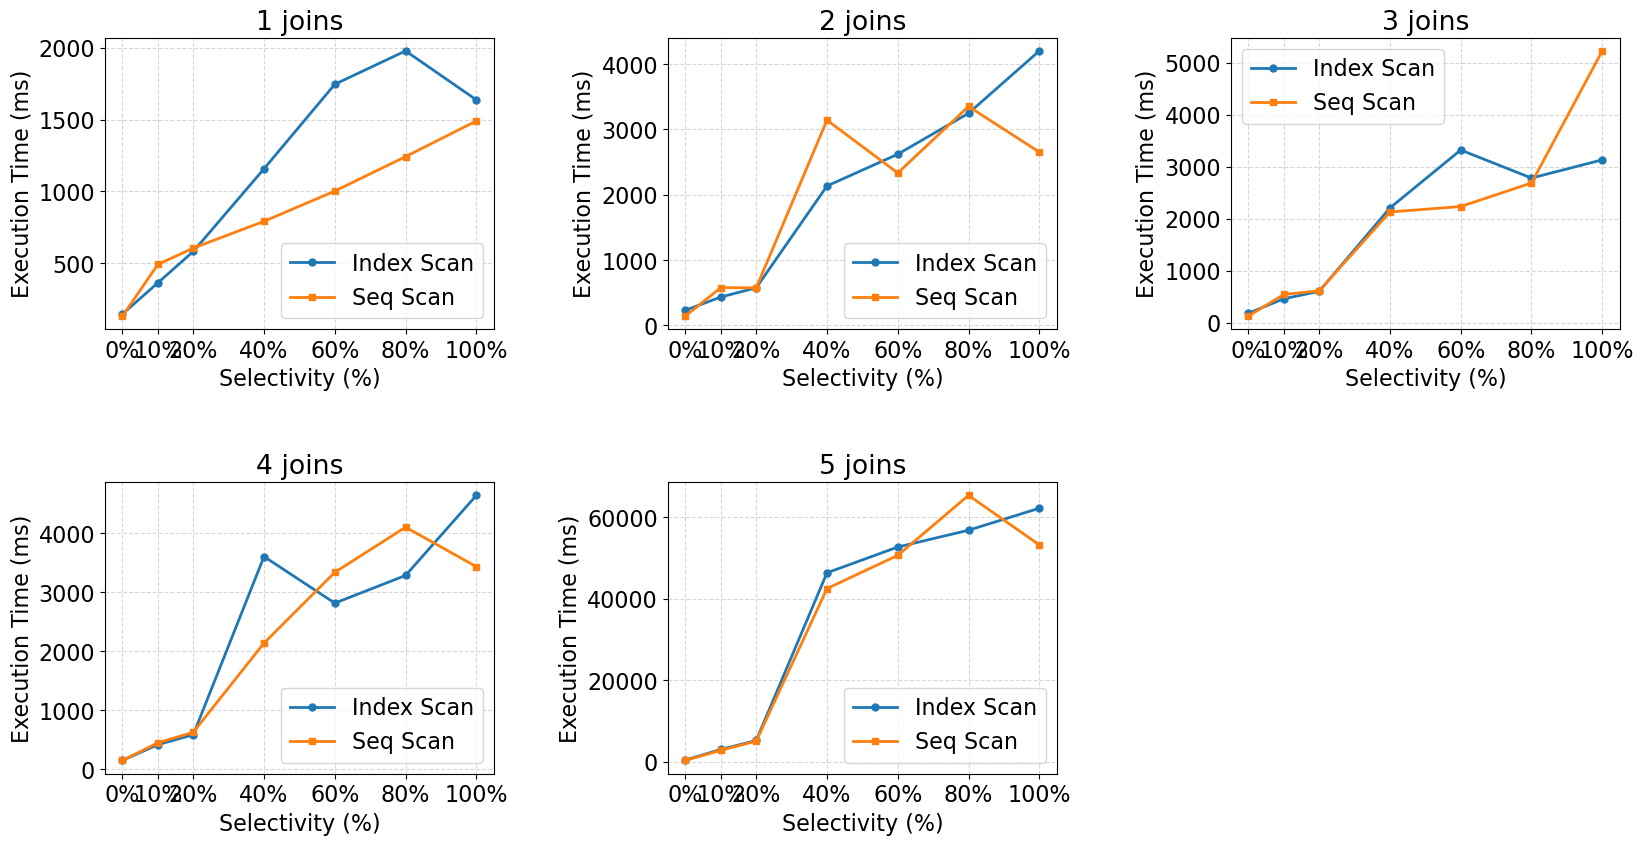

In [3]:
plots.plot_scan_latencies(synthetic_latencies, save_dir="plots/4.1/synthetic")

In [4]:
# 2. Get what each optimizer actually did (exec time and scan decision)
synthetic_scan_target = {'relation_name': 'movie_companies', 'alias': 'mc', 'column_name': 'company_id'}
synthetic_optimizer_data = utils.extract_optimizer_data(SYNTHETIC_ROOT, scan_target=synthetic_scan_target)
print("Synthetic optimizer data extracted.")
print(f"Found {len(synthetic_optimizer_data)} optimizer decisions for synthetic benchmark.")
print("Optimizer decisions:", synthetic_optimizer_data)
print("Extraction complete.")

# Plot the results for the synthetic benchmark
if synthetic_latencies and synthetic_optimizer_data:
    print("\nPlotting results for synthetic benchmark...")
    plots.plot_scan_decisions(
        synthetic_latencies, 
        synthetic_optimizer_data,
        save_dir="plots/4.1/synthetic/",
        show_title=False
    )
else:
    print("\nNo data found for synthetic benchmark, skipping plots.")

Synthetic optimizer data extracted.
Found 5 optimizer decisions for synthetic benchmark.
Optimizer decisions: {'3_joins_movie_company_2': {'PostgreSQL': {'40%': {'exec_time': 3101.619, 'scan_decision': 'seq_scan'}, '100%': {'exec_time': 2935.452, 'scan_decision': 'seq_scan'}, '60%': {'exec_time': 2270.333, 'scan_decision': 'seq_scan'}, '80%': {'exec_time': 2602.261, 'scan_decision': 'seq_scan'}, '20%': {'exec_time': 614.482, 'scan_decision': 'seq_scan'}, '10%': {'exec_time': 489.672, 'scan_decision': 'index_scan'}, '0%': {'exec_time': 159.507, 'scan_decision': 'index_scan'}}, 'NEO': {'40%': {'exec_time': 2285.54, 'scan_decision': 'seq_scan'}, '100%': {'exec_time': 3399.892, 'scan_decision': 'seq_scan'}, '60%': {'exec_time': 2780.515, 'scan_decision': 'seq_scan'}, '80%': {'exec_time': 3097.658, 'scan_decision': 'seq_scan'}, '20%': {'exec_time': 1595.203, 'scan_decision': 'seq_scan'}, '10%': {'exec_time': 2005.463, 'scan_decision': 'index_scan'}, '0%': {'exec_time': 142.579, 'scan_decisi

##### **Key takeaways**
- **NEO** tends to make and stick to wrong decisions in regards to the correct scan operator, regardless of the selectivity 
- **BAO and LERO** perform nearly flawlessly up to a certain threshold. However, beyond this point, they tend to favor sequential scans even when index scans would be faster.  
- **LOGER** is the only optimizer that deviates from this pattern by dynamically estimating the faster scan method rather than relying on a fixed threshold. (e.g. the synthetic query with 3 joins)
- **FASTgres** failed to find a context for any of the test queries, defaulting to PostgreSQL's optimizer plan without any modifications.  

#### ii. Complete Join Order Benchmark with an index on the title.production_year column

In [5]:
JOB_INDEX_ROOT = os.path.join(BASE_DIR, "4.1/added_index")
print("\nExtracting data for JOB benchmark with added index...")
# 1. Get ground-truth latencies
job_latencies = utils.extract_scan_latencies(JOB_INDEX_ROOT)


Extracting data for JOB benchmark with added index...


In [6]:
# 2. Get optimizer decisions and performance
job_scan_target = {'relation_name': 'title', 'alias': 't', 'column_name': 'production_year'}
job_optimizer_data = utils.extract_optimizer_data(JOB_INDEX_ROOT, scan_target=job_scan_target)
print("Extraction complete.")

Extraction complete.


In [7]:
# Plot the results for the added_index benchmark
if job_latencies and job_optimizer_data:
    print("\nPlotting results for added_index benchmark...")
    plots.plot_scan_decisions(
        job_latencies, 
        job_optimizer_data,
        save_dir="plots/4.1/added_index/",
        skip_neo=True,  # Skip NEO for this benchmark
        show_title=False
    )
else:
    print("\nNo data found for added_index benchmark, skipping plots.")


Plotting results for added_index benchmark...


In [8]:
plots.plot_aggregated_scan_performance(
    job_latencies, 
    job_optimizer_data,
    save_dir="plots/4.1_with_titles/added_index/"    
)

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/experiments/experiment4/plotting_methods.py:306: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dist_data = df.groupby(['complexity_bin', 'optimizer', 'scan_decision']).size().unstack(fill_value=0)


Saving plot: plots/4.1_with_titles/added_index/scan_dist_1-4_Joins.png
Saving plot: plots/4.1_with_titles/added_index/scan_dist_5-8_Joins.png
Saving plot: plots/4.1_with_titles/added_index/scan_dist_9-12_Joins.png
Saving plot: plots/4.1_with_titles/added_index/scan_dist_13-16_Joins.png


### Experiment 4.2

Analyse the composition of operators selected from each optimizer

- **Optimal Composition**: Break down the composition of physical operators in the optimal plans for the workload.
- **Classic Optimizer Composition**: Analyze the composition of physical operators proposed by the traditional optimizer.
- **LQO Composition**: Compare the composition of physical operators proposed by each LQO.

**Goal**: Understand how the choice of physical operators differs between optimal plans, classic optimizers, and LQOs, and how these choices impact performance."			

In [9]:
OPERATOR_ROOT = os.path.join(BASE_DIR, "4.2")

OPTIMAL_PLANS_DIR = f"{REPO_ROOT}/preprocessing/optimal_plans/job"
operator_counts, operator_exec_times = utils.analyze_join_operators(OPERATOR_ROOT,OPTIMAL_PLANS_DIR)
print("Analysis complete. Found data for the following join levels:", sorted(operator_counts.keys()))

Processing main experiment directory...
Processing optimal plans directory: /data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/optimal_plans/job
Analysis complete. Found data for the following join levels: ['10', '11', '12', '13', '14', '16', '17', '18', '19', '20', '21', '23', '28', '4', '5', '6', '7', '8', '9']


In [10]:
print("\nGenerating plots...")

plots.plot_join_operator_composition(
    operator_counts,
    operator_exec_times,save_dir="plots/4.2/"
)

print("\nAll plots generated.")


Generating plots...
Saving plot: plots/4.2/join_level_10.png
Saving plot: plots/4.2/join_level_11.png
Saving plot: plots/4.2/join_level_12.png
Saving plot: plots/4.2/join_level_13.png
Saving plot: plots/4.2/join_level_14.png
Saving plot: plots/4.2/join_level_16.png
Saving plot: plots/4.2/join_level_17.png
Saving plot: plots/4.2/join_level_18.png
Saving plot: plots/4.2/join_level_19.png
Saving plot: plots/4.2/join_level_20.png
Saving plot: plots/4.2/join_level_21.png
Saving plot: plots/4.2/join_level_23.png
Saving plot: plots/4.2/join_level_28.png
Saving plot: plots/4.2/join_level_4.png
Saving plot: plots/4.2/join_level_5.png
Saving plot: plots/4.2/join_level_6.png
Saving plot: plots/4.2/join_level_7.png
Saving plot: plots/4.2/join_level_8.png
Saving plot: plots/4.2/join_level_9.png

All plots generated.


### Experiment 4.3

- **Predicted vs. Actual Latency**: Measure the LQO’s predicted latency for plans using forced join or scan operators and compare it to the actual execution latency.
- **Bias Detection**: Analyze whether the LQO systematically overestimates or underestimates the latency of specific operators.

**Goal**: Understand the accuracy and reliability of the LQO's latency predictions for different operators, and identify any inherent biases that may impact the quality of the generated query plans.

In [11]:
EXP_ROOT = os.path.join(BASE_DIR, "4.3")

print(f"Collecting data for Experiment 4.3 from: {EXP_ROOT}")
df_metrics = utils.collect_prediction_vs_actual_metrics(EXP_ROOT)

if df_metrics.empty:
    print("Data collection complete, but no data was found. Please check paths and file contents.")


Generating prediction vs. actual latency plots...


Saving plot: plots/4.3/join_level_4_predictions.png


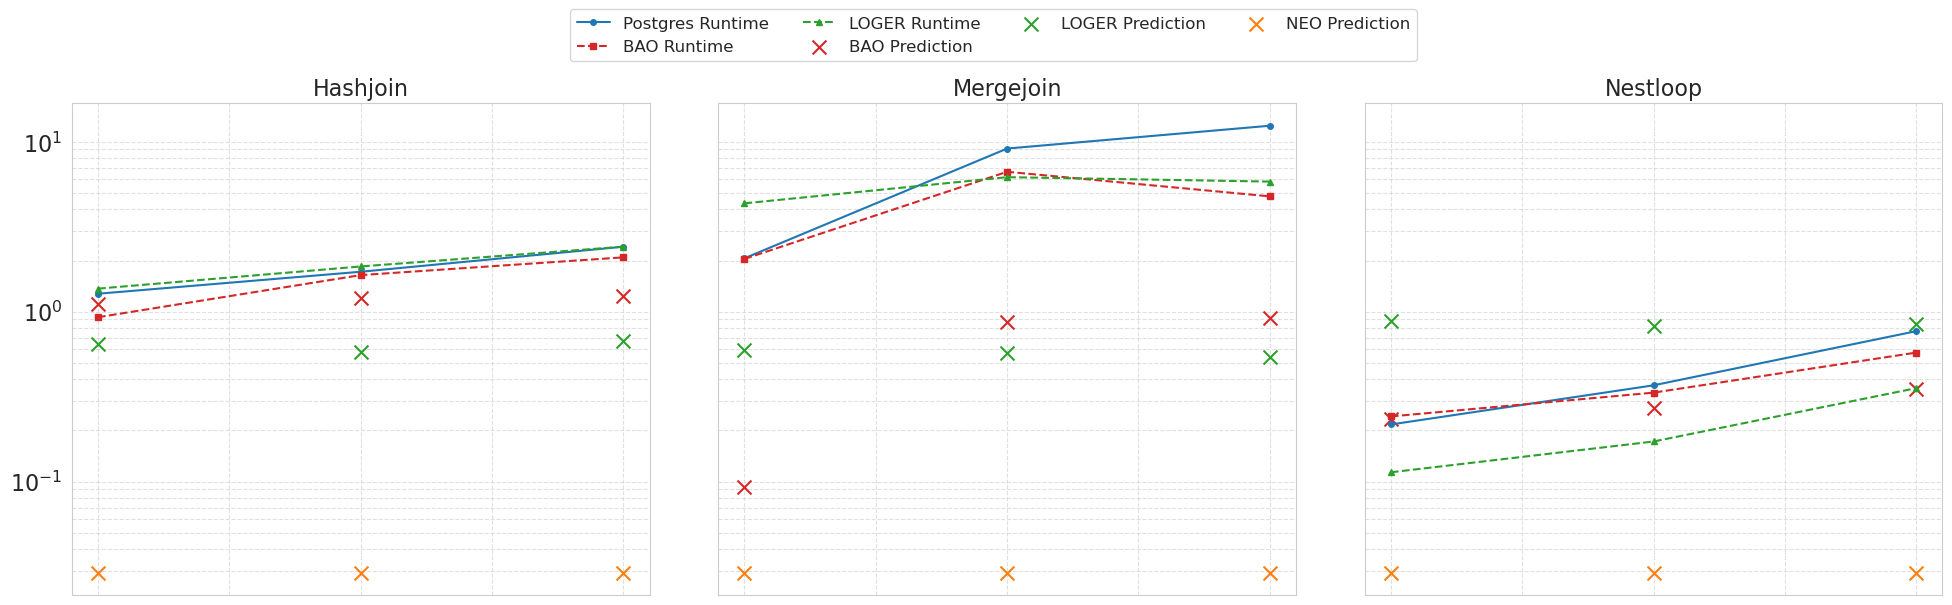

Saving plot: plots/4.3/join_level_5_predictions.png


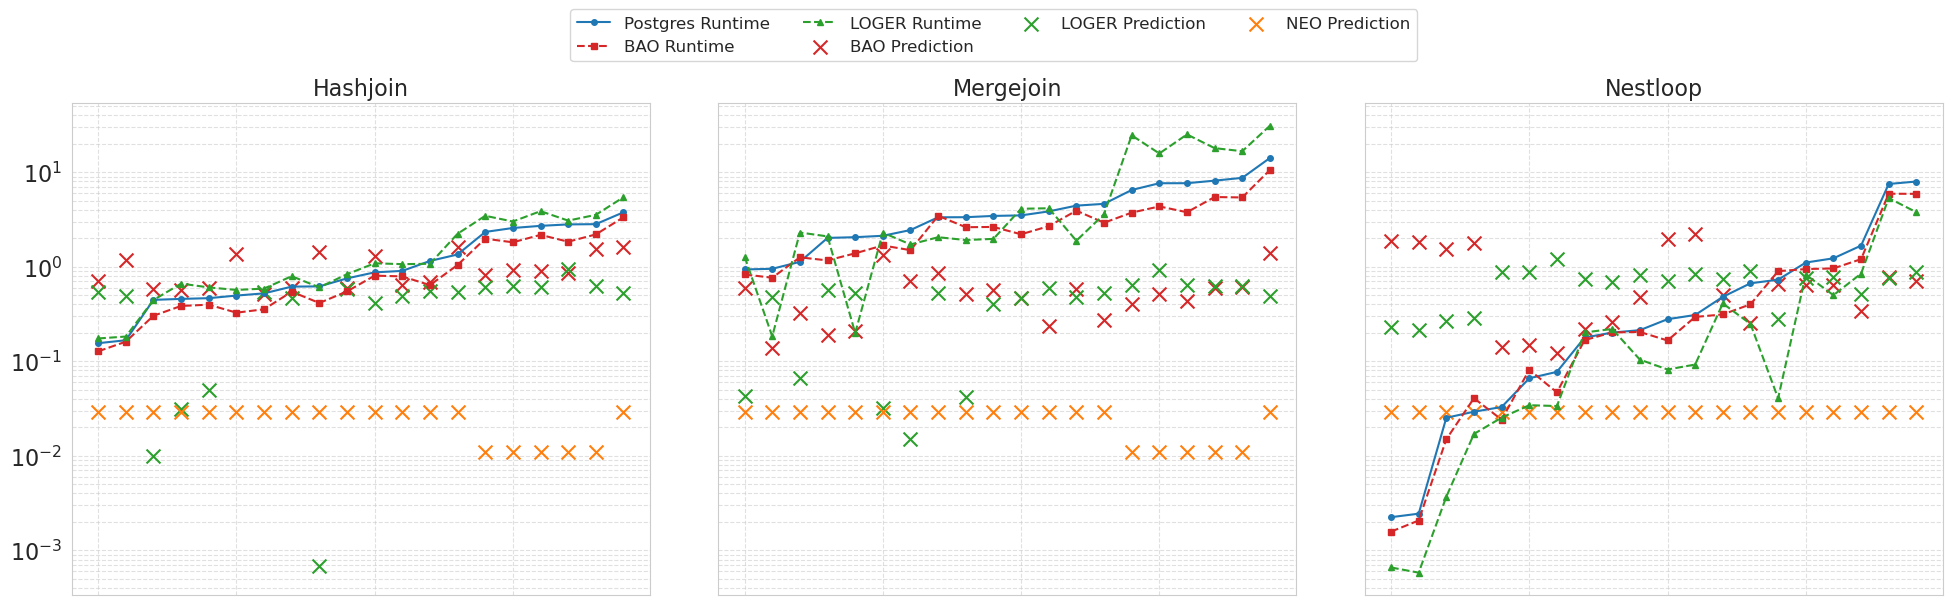

Saving plot: plots/4.3/join_level_6_predictions.png


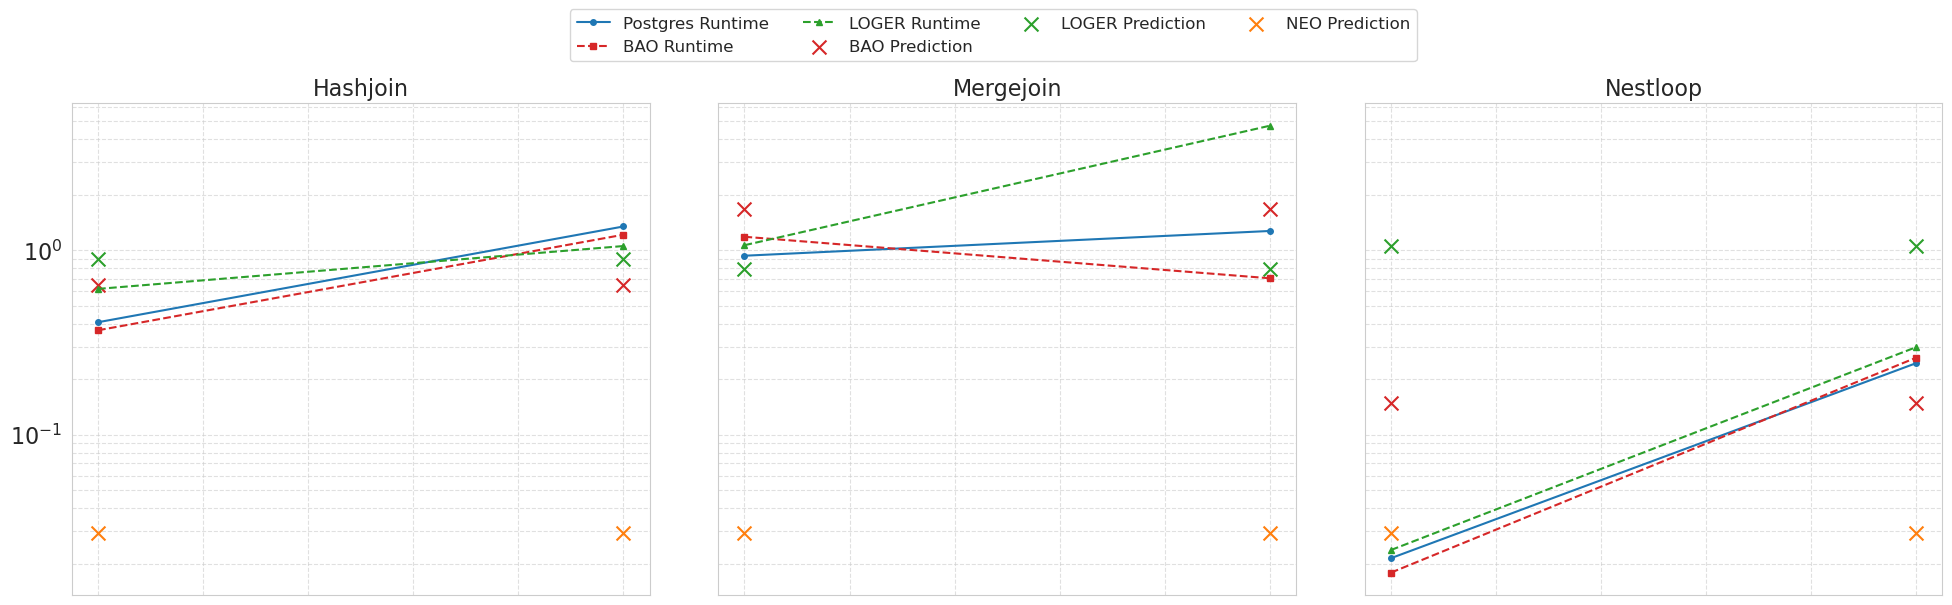

Saving plot: plots/4.3/join_level_7_predictions.png


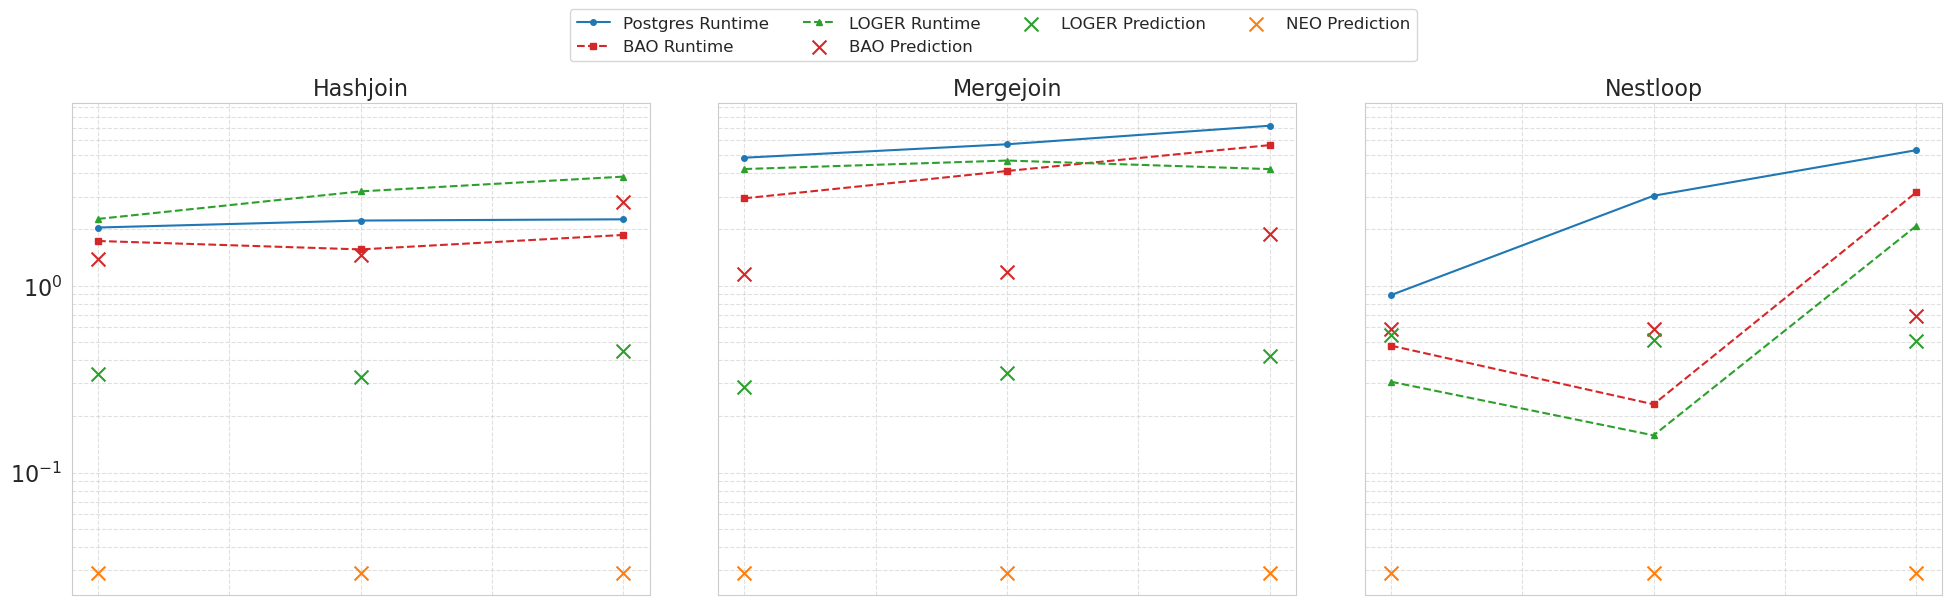

Saving plot: plots/4.3/join_level_8_predictions.png


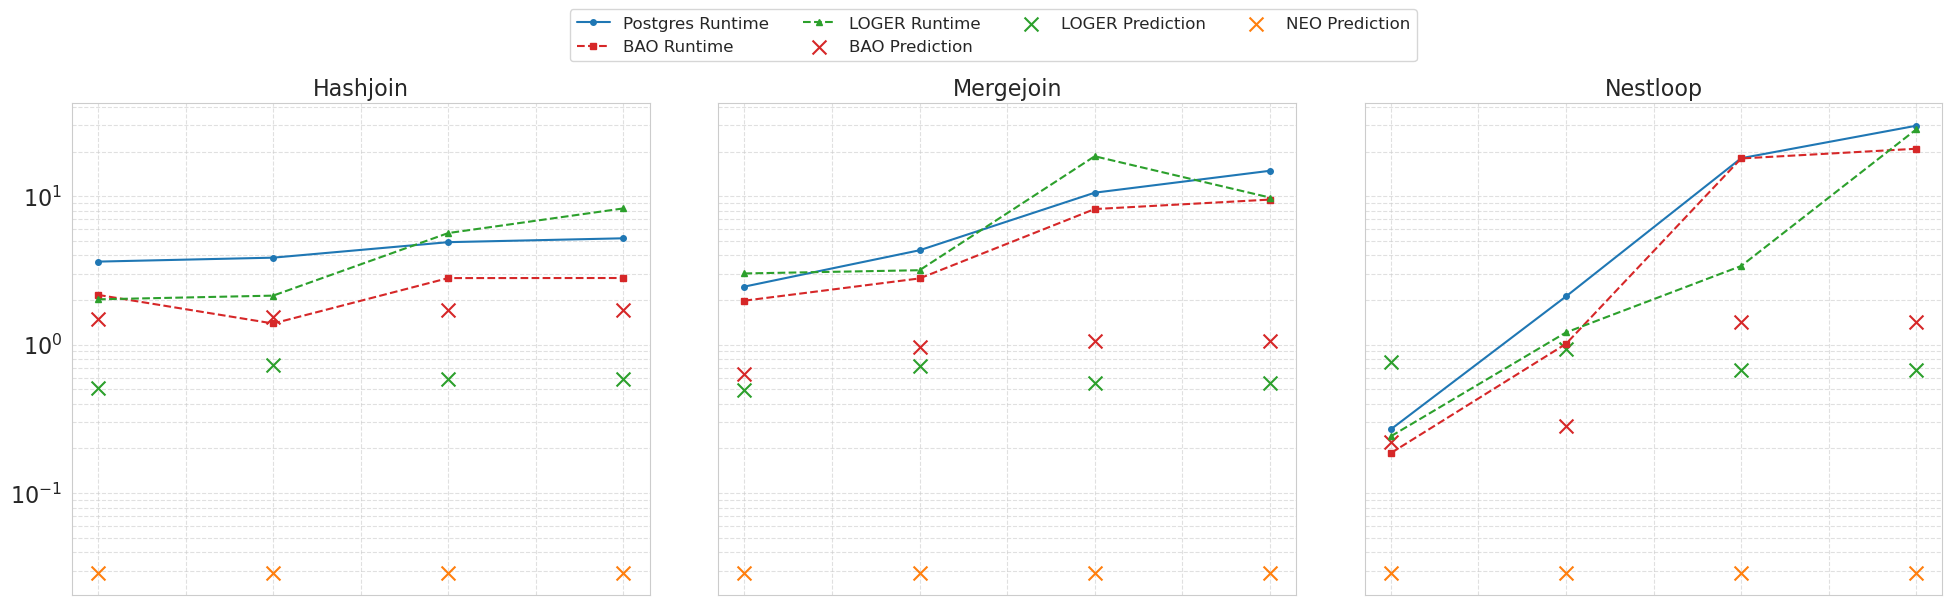

Saving plot: plots/4.3/join_level_9_predictions.png


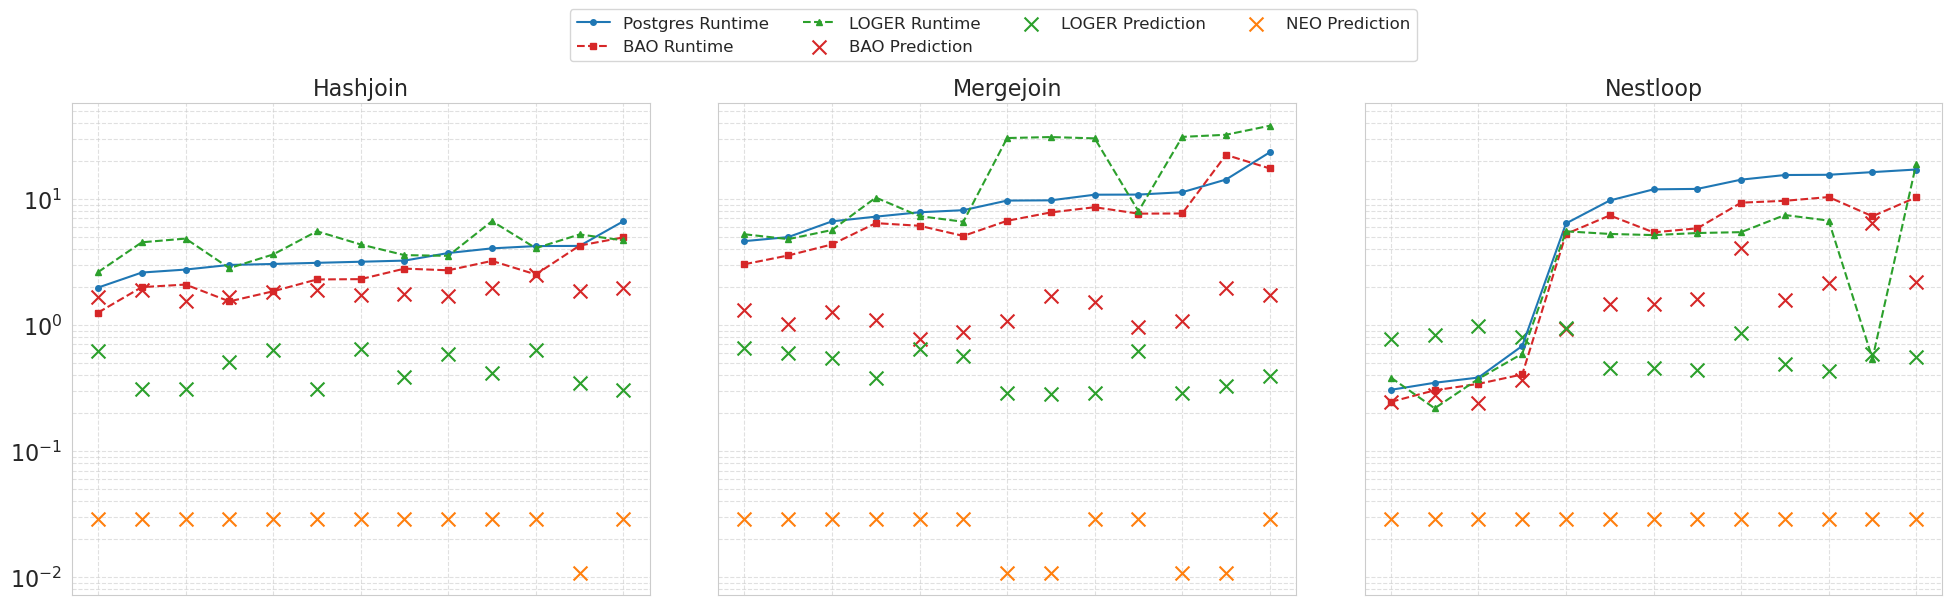

Saving plot: plots/4.3/join_level_10_predictions.png


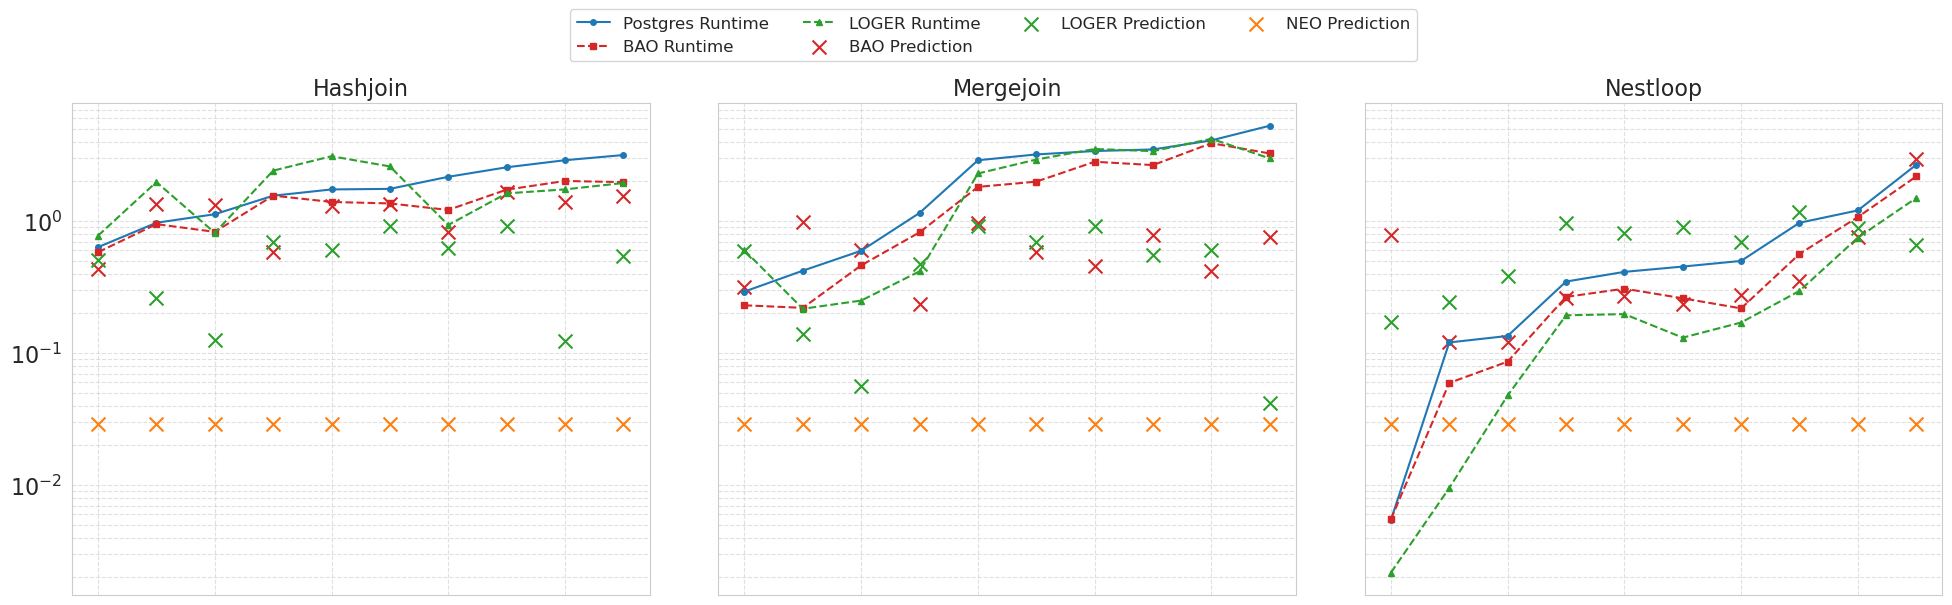

Saving plot: plots/4.3/join_level_11_predictions.png


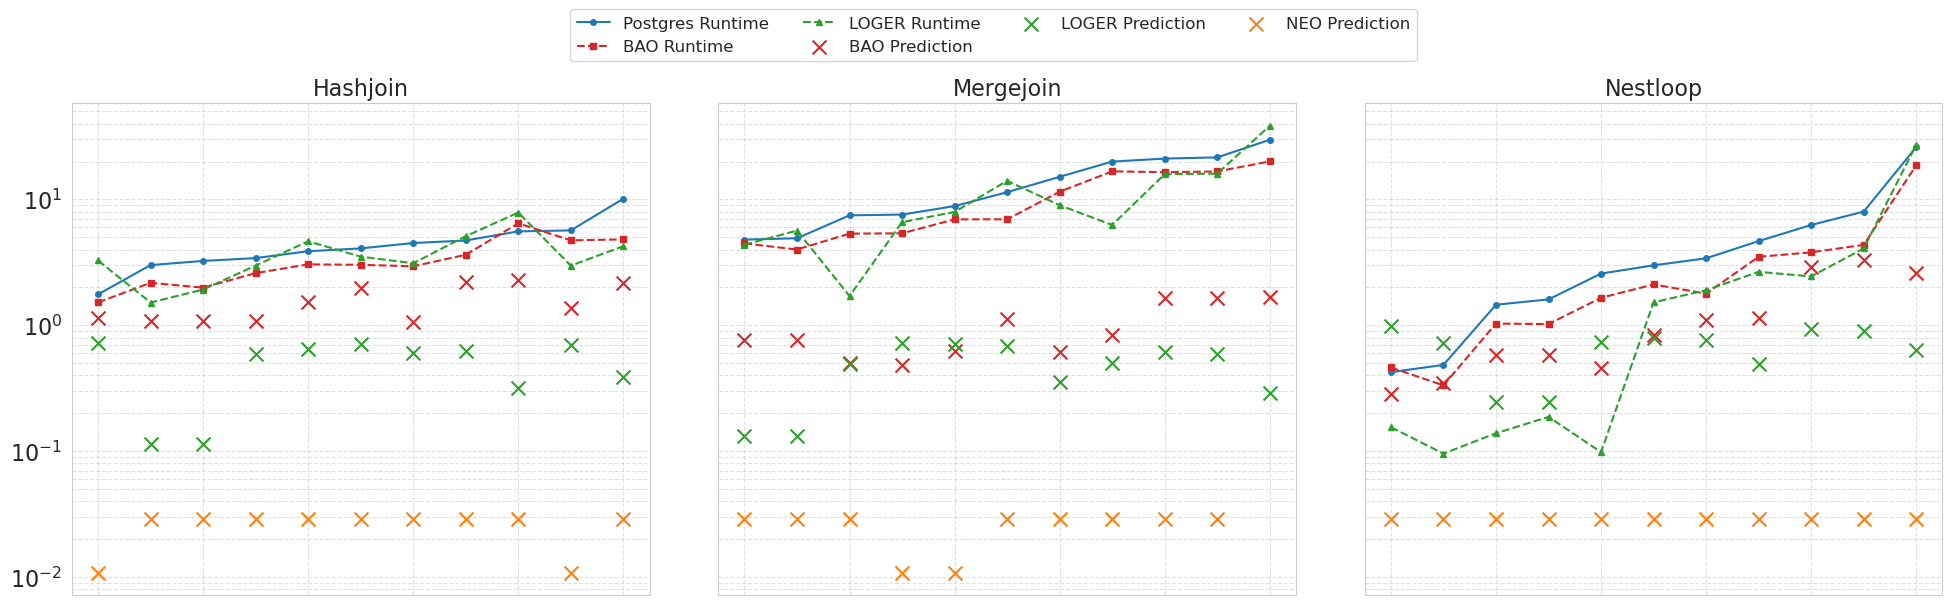

Saving plot: plots/4.3/join_level_12_predictions.png


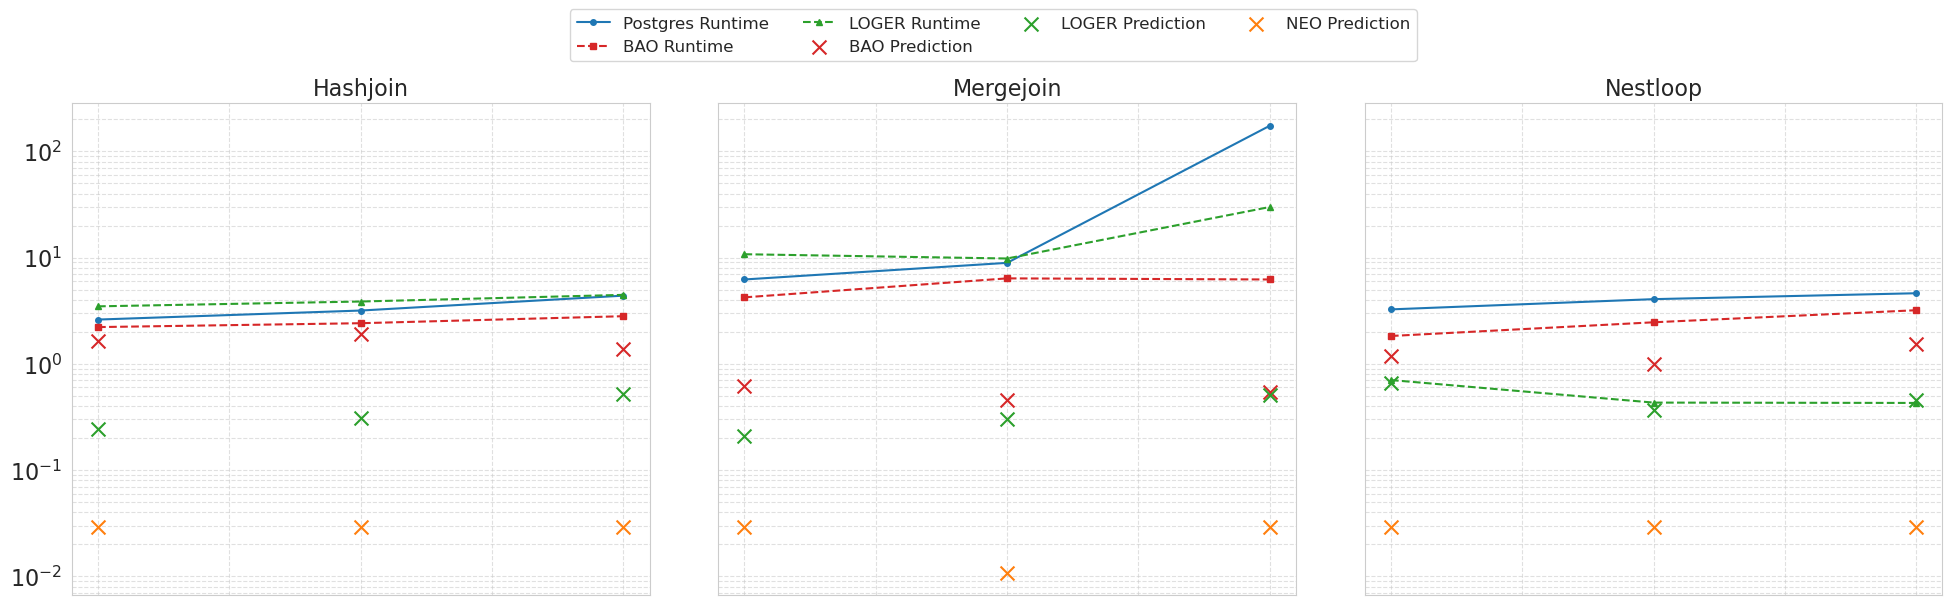

Saving plot: plots/4.3/join_level_13_predictions.png


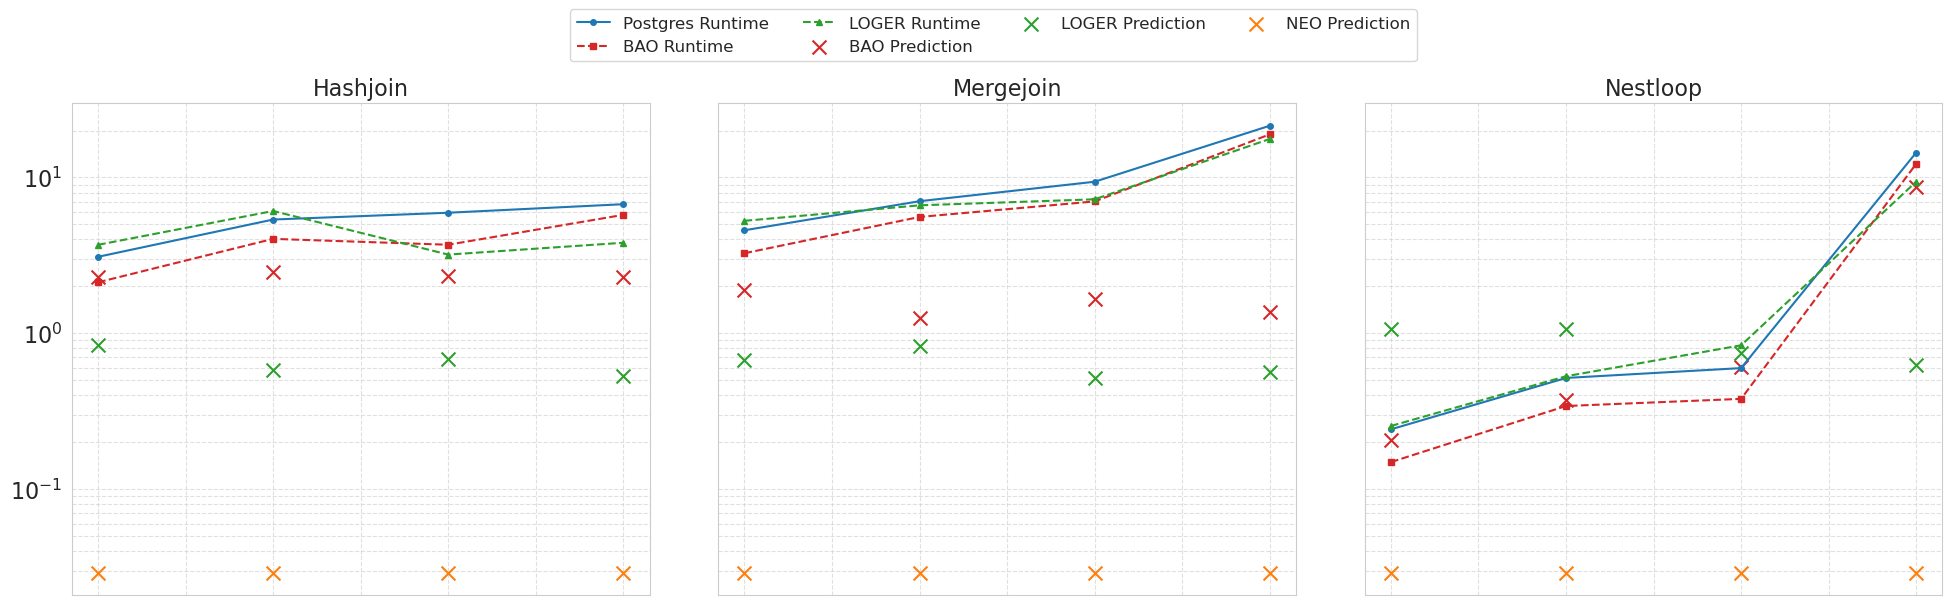

Saving plot: plots/4.3/join_level_14_predictions.png


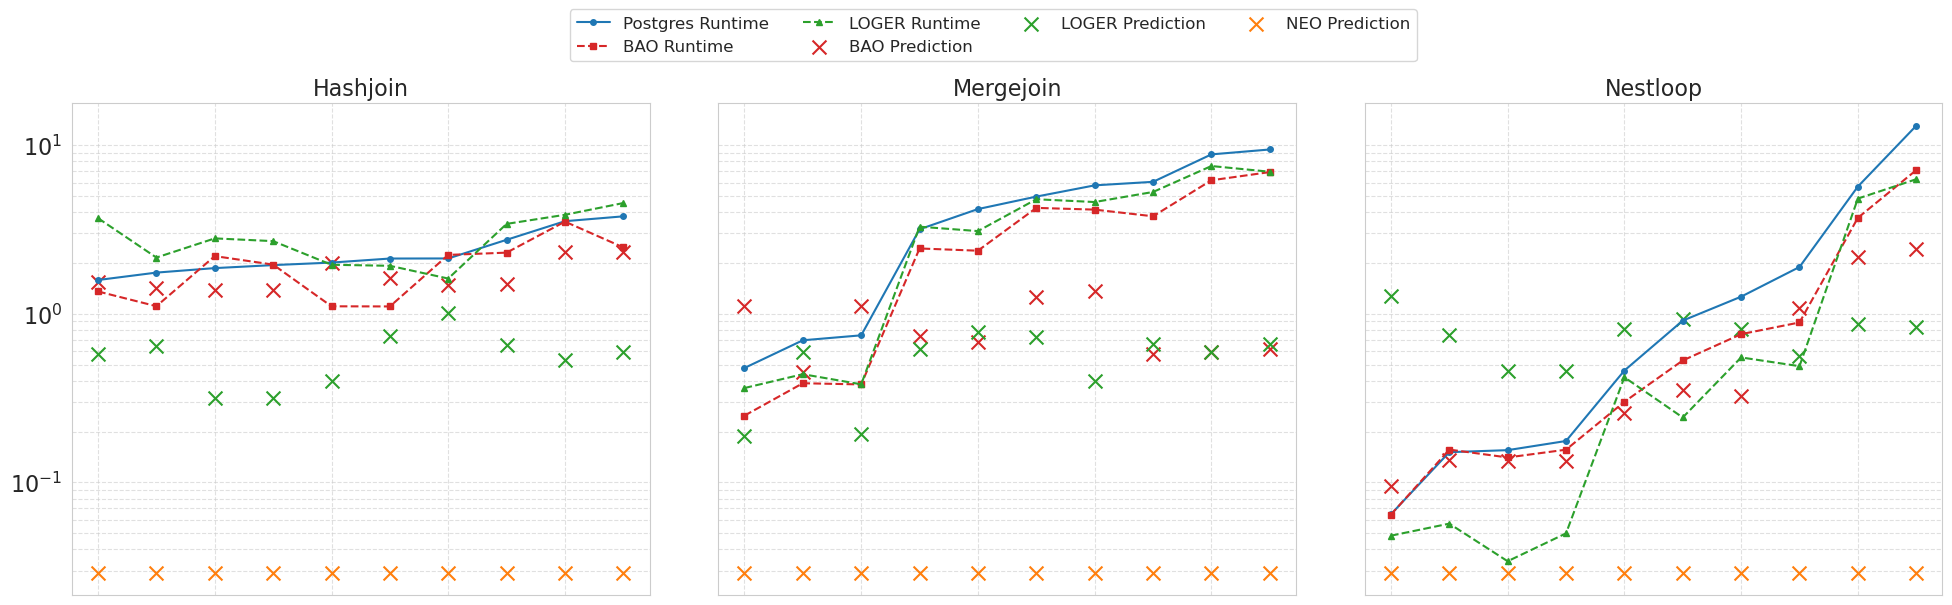

Saving plot: plots/4.3/join_level_16_predictions.png


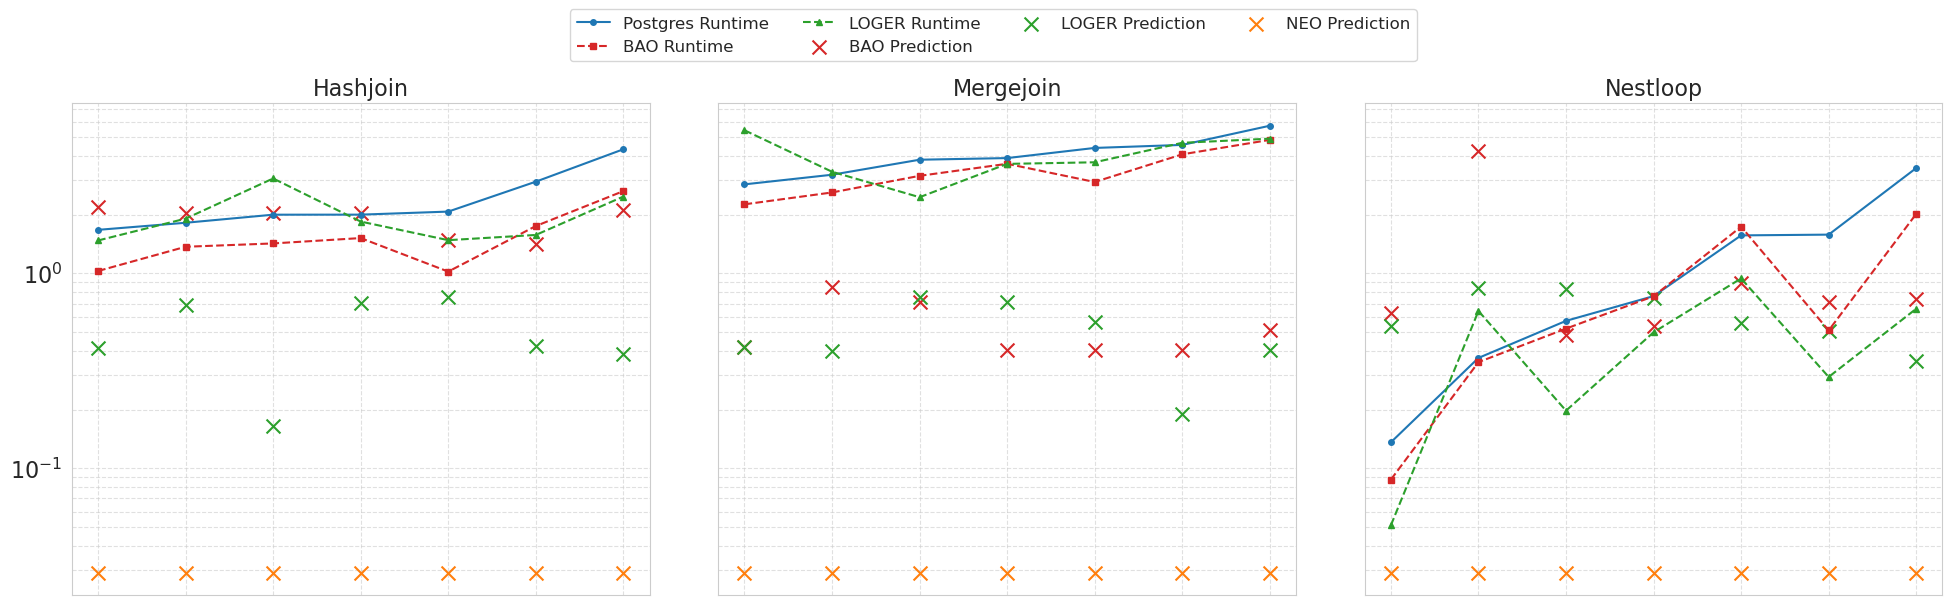

Saving plot: plots/4.3/join_level_17_predictions.png


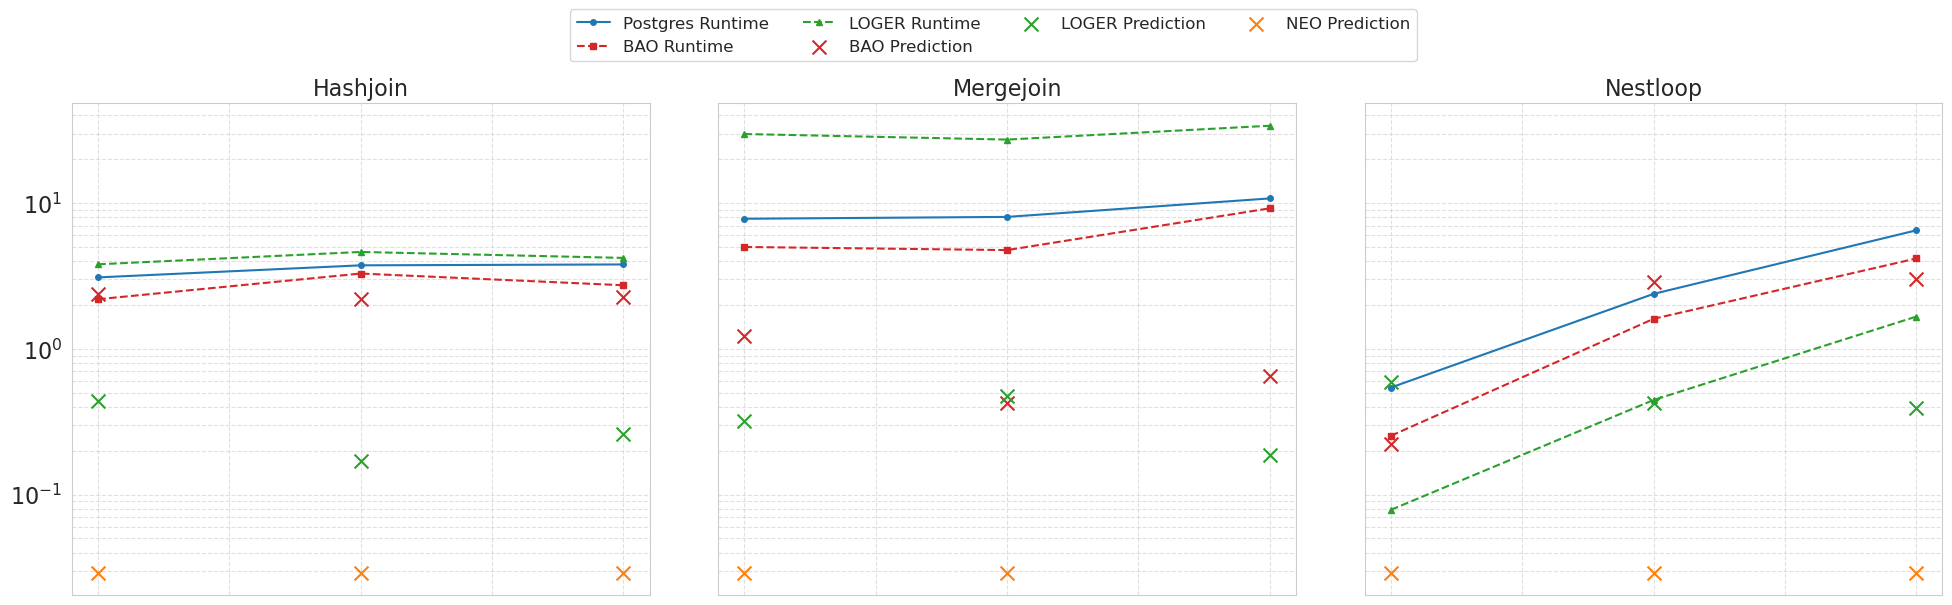

Saving plot: plots/4.3/join_level_18_predictions.png


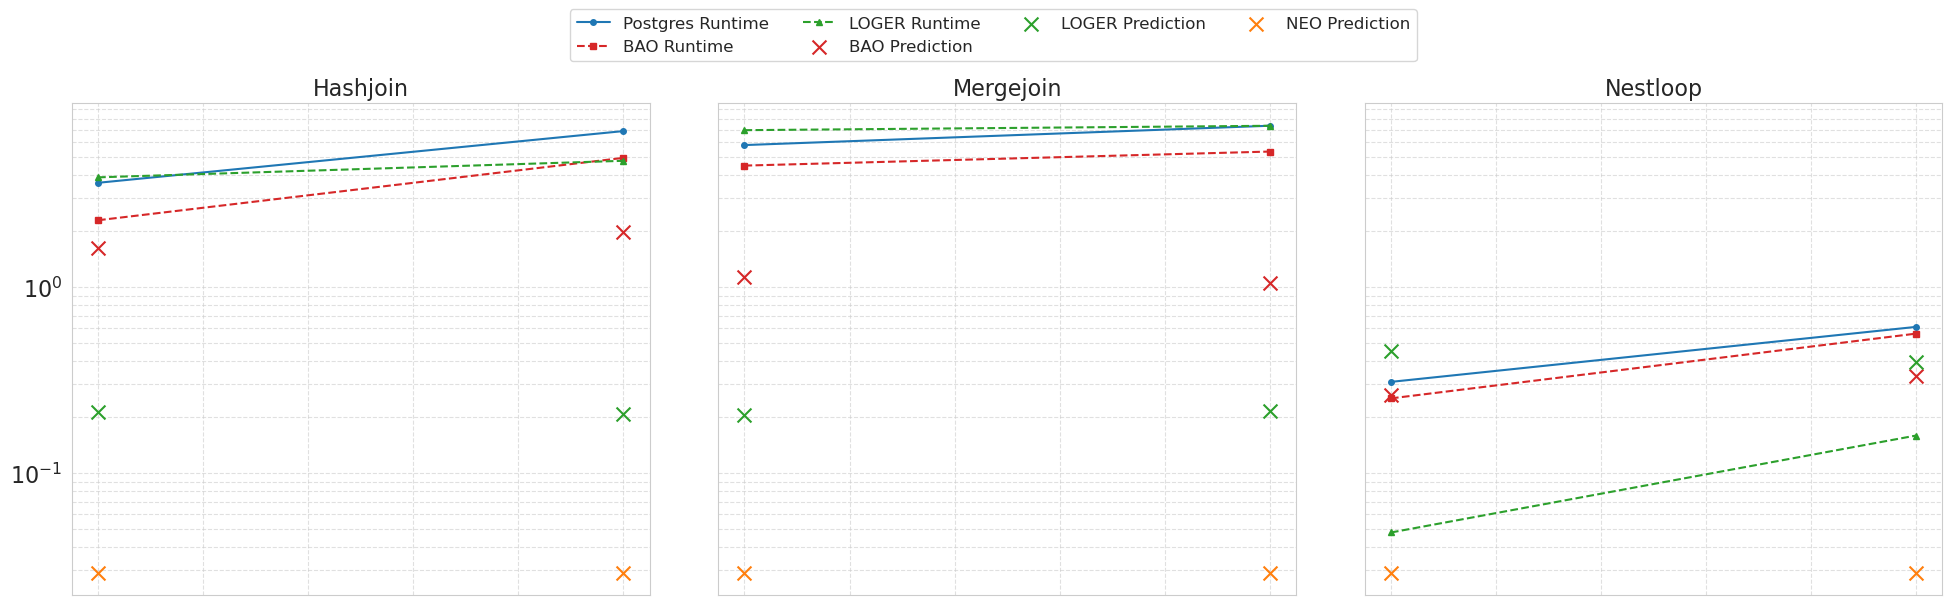

Saving plot: plots/4.3/join_level_19_predictions.png


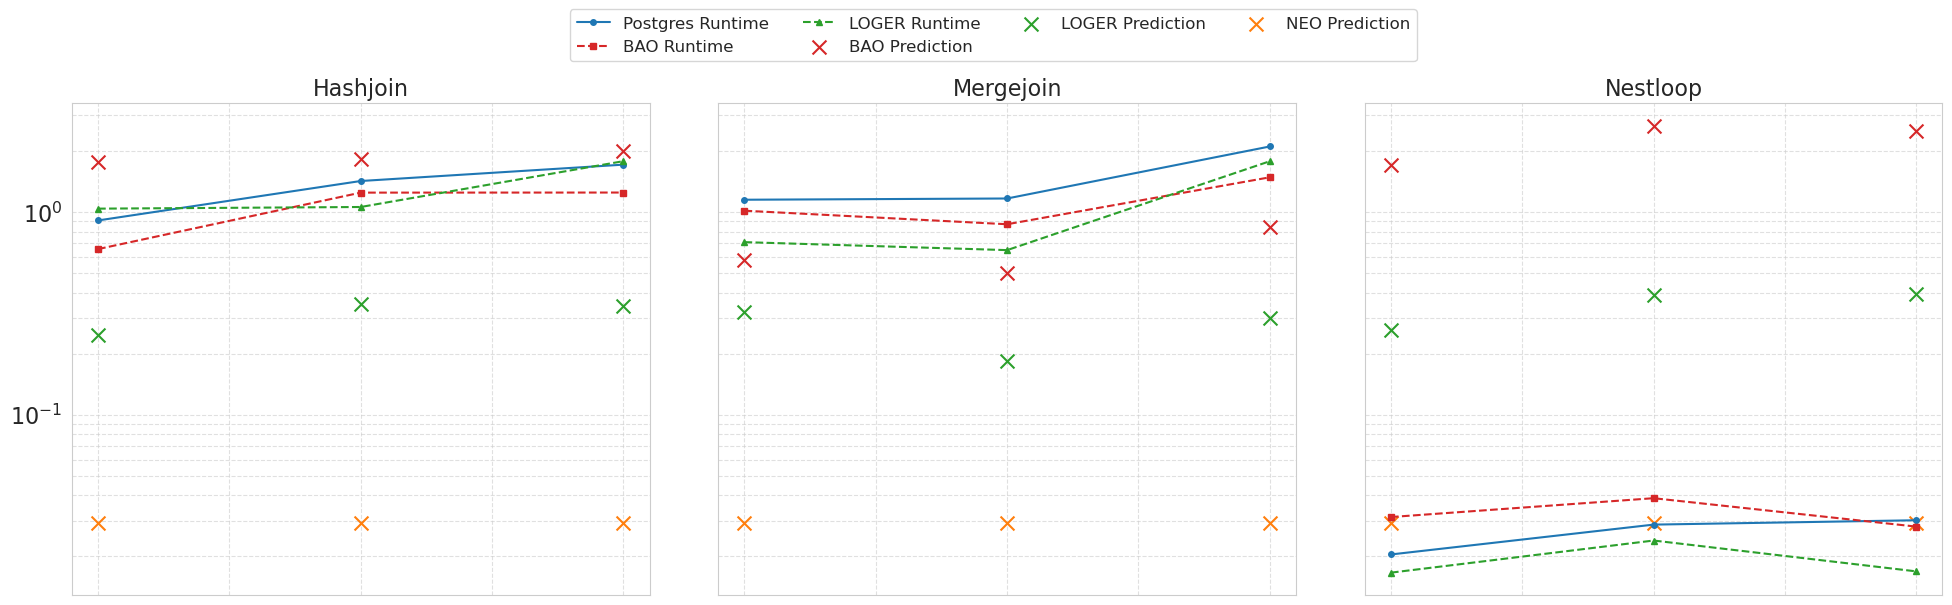

Saving plot: plots/4.3/join_level_20_predictions.png


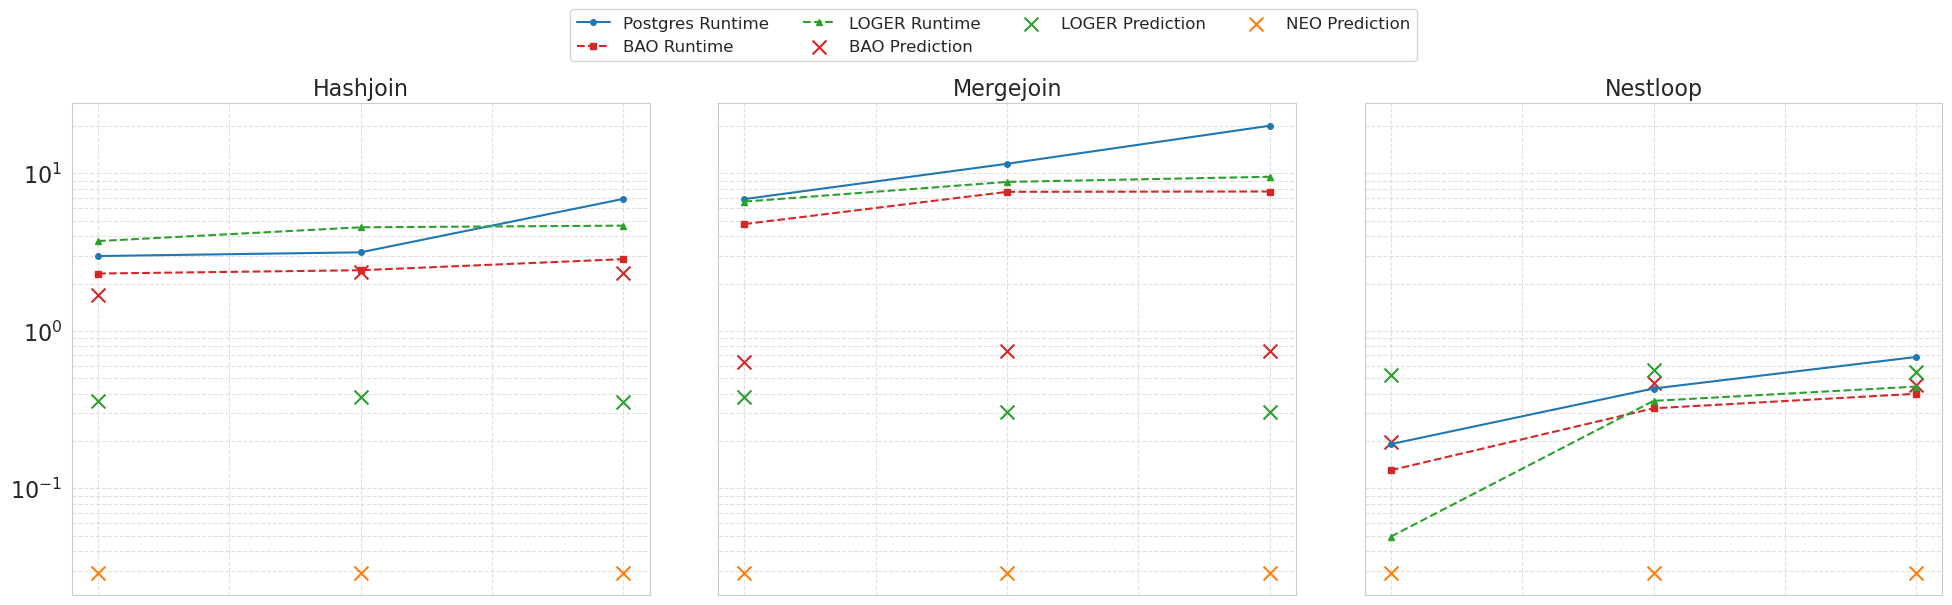

Saving plot: plots/4.3/join_level_21_predictions.png


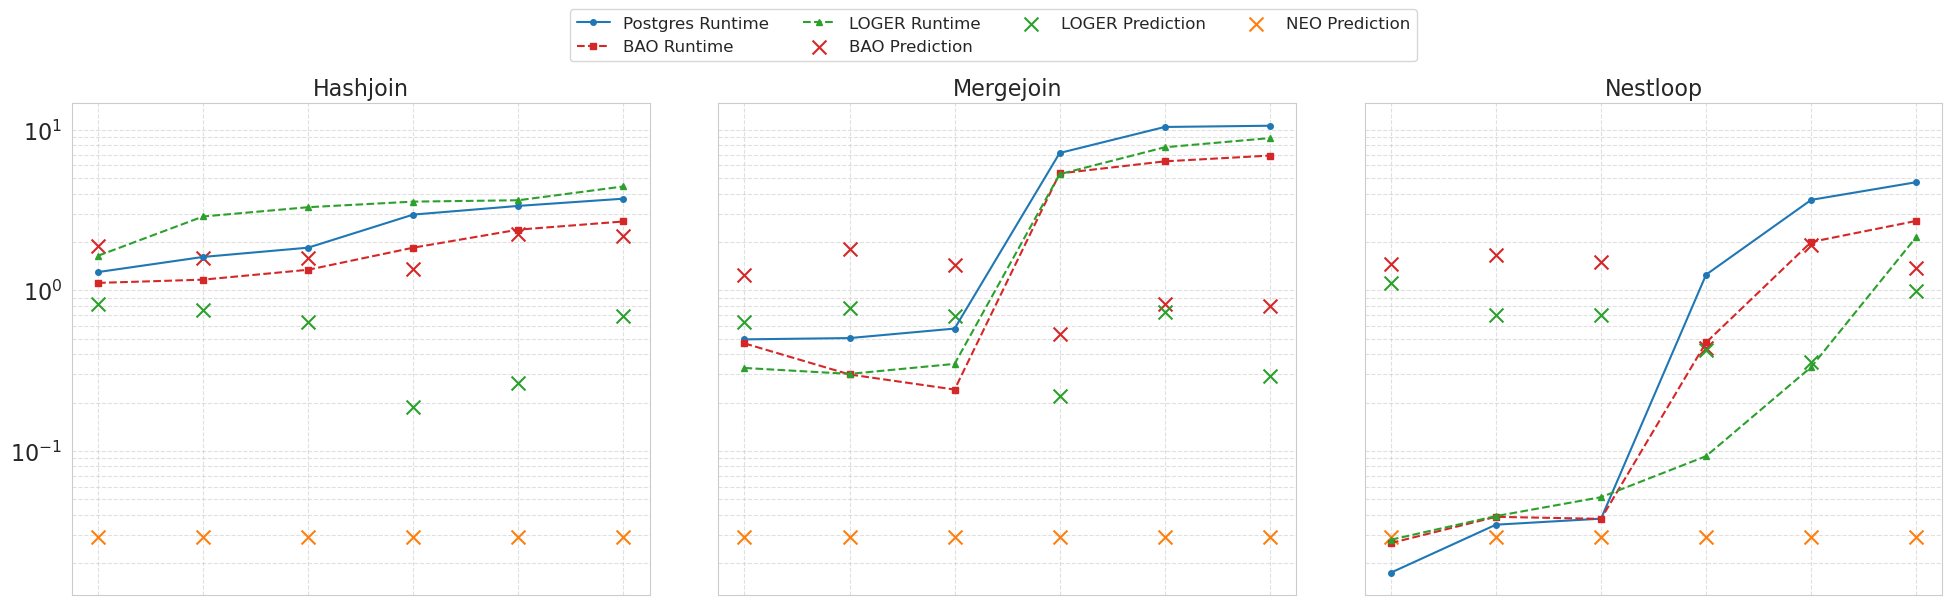

Saving plot: plots/4.3/join_level_23_predictions.png


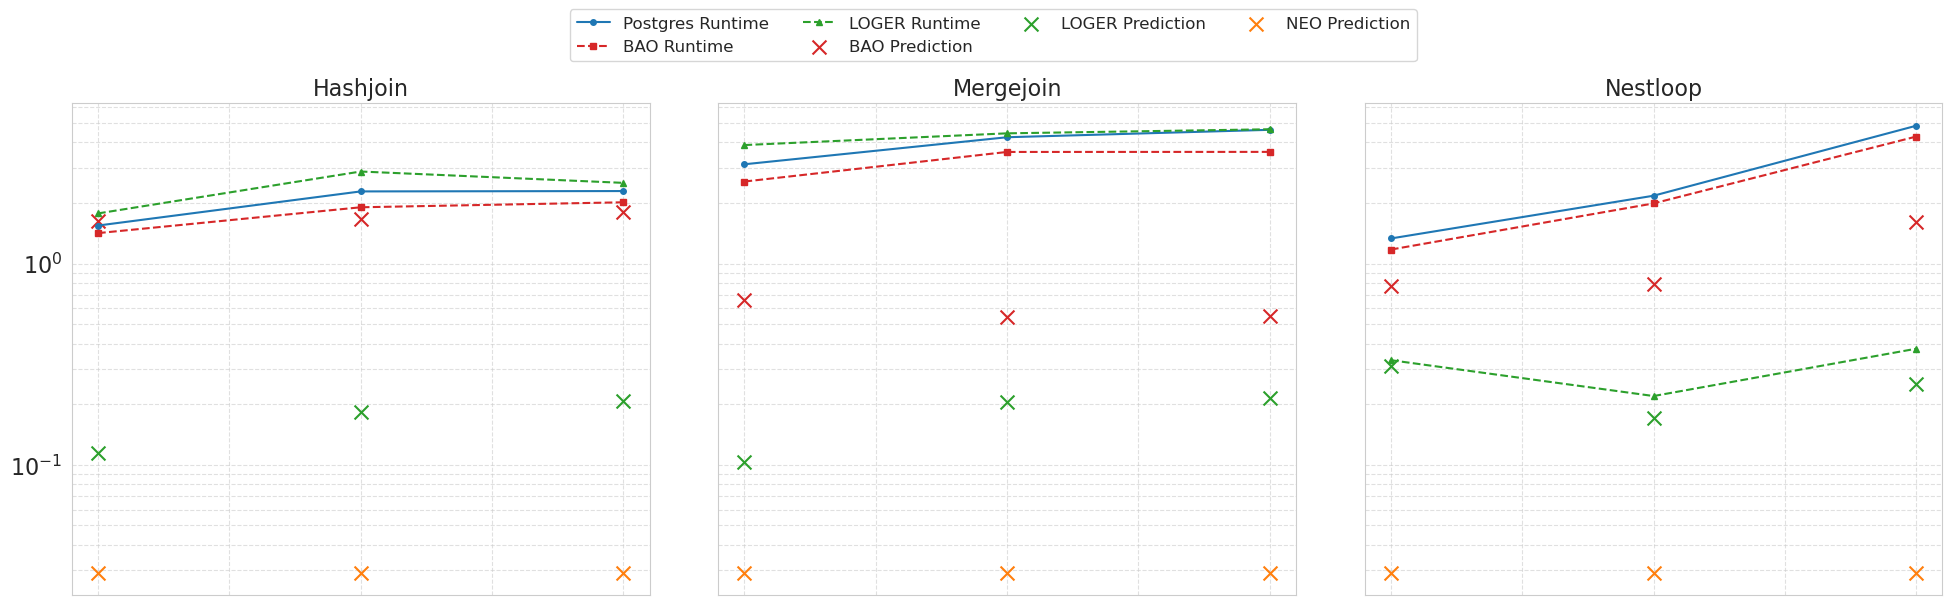

Saving plot: plots/4.3/join_level_28_predictions.png


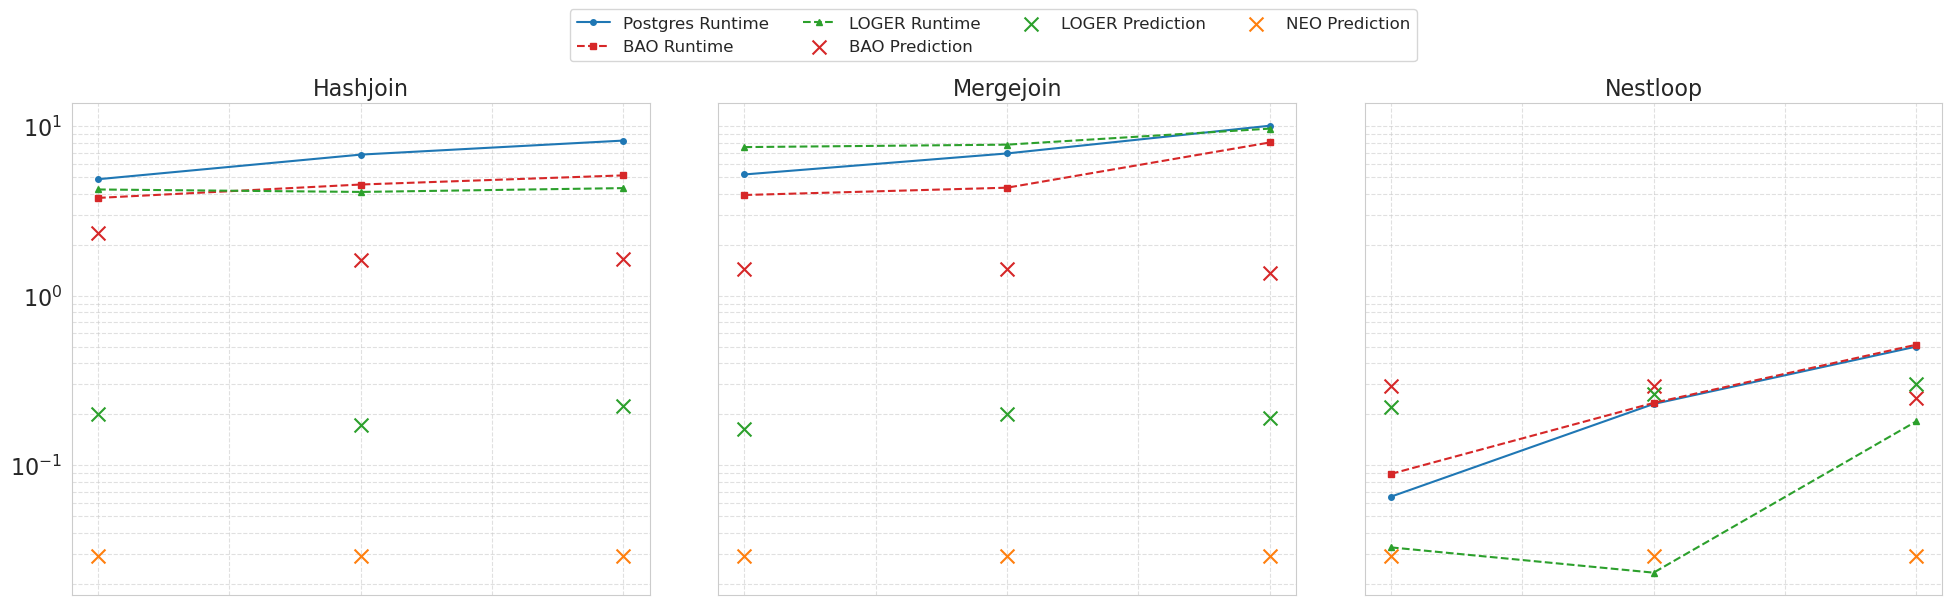


All plots generated.


In [12]:
print("\nGenerating prediction vs. actual latency plots...")
plots.plot_prediction_vs_actual(df_metrics)
print("\nAll plots generated.")

### Experiment 4.4

Exam the relationship between plan embeddings and plan quality.

Train: JOB

Test: JOB ran twice on each LQO. Once with LQO-generated plans and once with PostgreSQL gennerated plans.

For both executions per query, we store the embeddings that are generated within the confines of the LQO. 

Later, we compare per query the 2 query plans by a) their cosine distance vs their relative difference in execution latency and b) where each query plan lies within the embedding space

In [13]:
# NOTE: The data source for this analysis is the 4.2 directory.
EXP_ROOT = os.path.join(BASE_DIR, "4.4")
PLOTS_DIR = os.path.join(BASE_DIR, "plots/4.4")
# Load and process all the data from the generated files.
print(f"Loading data from workload directory: {EXP_ROOT}")
analysis_df = utils.load_embedding_analysis_data(EXP_ROOT)
print(f"Data loaded. Found {len(analysis_df)} records for analysis.")
print("\nAnalyzing embedding distances and speedups...")
if not analysis_df.empty:
    # Print a high-level summary of the results.
    print("\n" + "="*30)
    print("High-level analysis of embedding distances and speedups:")
    print("="*30 + "\n")
    
    print("\nDetailed Analysis Results:")
    print(analysis_df.describe())

    print(analysis_df.head())

Loading data from workload directory: /data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/experiments/experiment4/4.4
Found 113 queries with BAO results to analyze.


Processing Queries: 100%|██████████| 113/113 [00:00<00:00, 2133.95it/s]

Data loaded. Found 113 records for analysis.

Analyzing embedding distances and speedups...

High-level analysis of embedding distances and speedups:


Detailed Analysis Results:
       embedding_distance  speedup_factor    bao_time_ms    pg_time_ms
count        1.130000e+02      113.000000     113.000000    113.000000
mean         1.276756e-14        1.044533    3938.884062   2650.390407
std          5.997810e-15        0.596402   20176.734592   7046.897584
min          3.330669e-15        0.128975      22.057000     17.016000
25%          8.215650e-15        0.839383     205.388000    164.625000
50%          1.154632e-14        0.974308     561.519000    423.308000
75%          1.565414e-14        1.017073    2064.543000   2190.184000
max          3.708145e-14        4.060289  205824.297000  61940.869000
  query_name run_id  embedding_distance  speedup_factor  bao_time_ms  \
0        16b   run1        9.658940e-15        3.210087     5989.336   
1        13a   run1        6.106227e-1

In [14]:
# NOTE: The data source for this analysis is the 4.2 directory.
EXP_ROOT = os.path.join(BASE_DIR, "4.4")
PLOTS_DIR = os.path.join(BASE_DIR, "plots/4.4")
from scipy.stats import gmean
# Load and process all the data from the generated files.
# Load data for all optimizers found in the base directory
df_all = utils.load_all_optimizer_data(EXP_ROOT)

if not df_all.empty:
    # df_all.dropna(inplace=True)

    print("\n" + "="*50)
    print("--- Overall Analysis Summary ---")
    print(f"Total valid query runs analyzed across all optimizers: {len(df_all)}")
    
    # Display summary statistics for each optimizer
    summary = df_all.groupby('optimizer').agg(
        num_queries=('query_name', 'count'),
        median_distance=('embedding_distance', 'median'),
        avg_speedup=('speedup_factor', gmean),
        win_rate=('speedup_factor', lambda x: (x > 1.0).mean())
    ).reset_index()
    
    summary['win_rate'] = summary['win_rate'].apply(lambda x: f"{x:.1%}")
else:
    print("\nNo valid data was loaded. Please check the BASE_EXPERIMENT_DIR path and ensure optimizer subdirectories exist.")

Starting recursive search for optimizer data in: /data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/experiments/experiment4/4.4

--- Searching for NEO results... ---
Found 113 queries with NEO results to analyze.


Processing NEO: 100%|██████████| 113/113 [00:00<00:00, 2284.12it/s]



--- Searching for BAO results... ---
Found 113 queries with BAO results to analyze.


Processing BAO: 100%|██████████| 113/113 [00:00<00:00, 2122.02it/s]



--- Searching for LERO results... ---
Found 113 queries with LERO results to analyze.


Processing LERO:   0%|          | 0/113 [00:00<?, ?it/s]

Processing LERO: 100%|██████████| 113/113 [00:00<00:00, 3946.31it/s]



--- Searching for LOGER results... ---
Found 339 queries with LOGER results to analyze.


Processing LOGER: 100%|██████████| 339/339 [00:00<00:00, 2313.93it/s]



--- Searching for FASTgres results... ---
No 'FASTgres' subdirectories found. Skipping.

--- Overall Analysis Summary ---
Total valid query runs analyzed across all optimizers: 642


Final analysis plot saved to: /data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/experiments/experiment4/plots/4.4/embedding_divergence_final.png


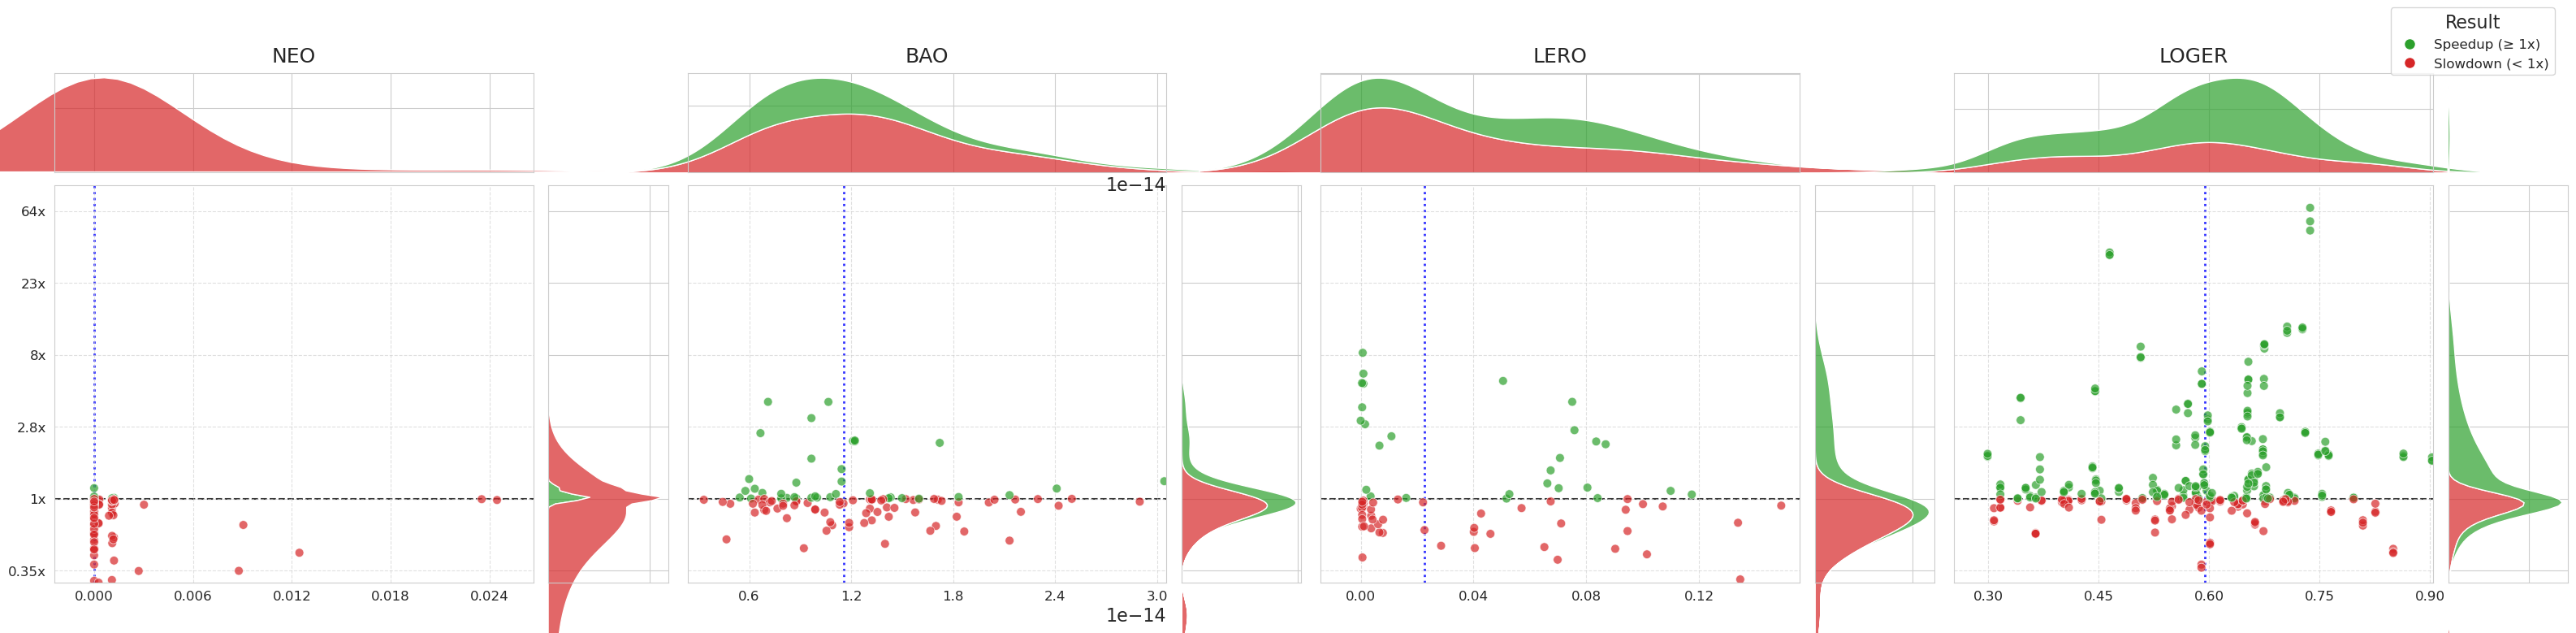

In [15]:
plots.plot_divergence_final(df_all, PLOTS_DIR)

Zoomed scatter plot saved to: /data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/experiments/experiment4/plots/4.4/embedding_divergence_scatter_zoomed.png


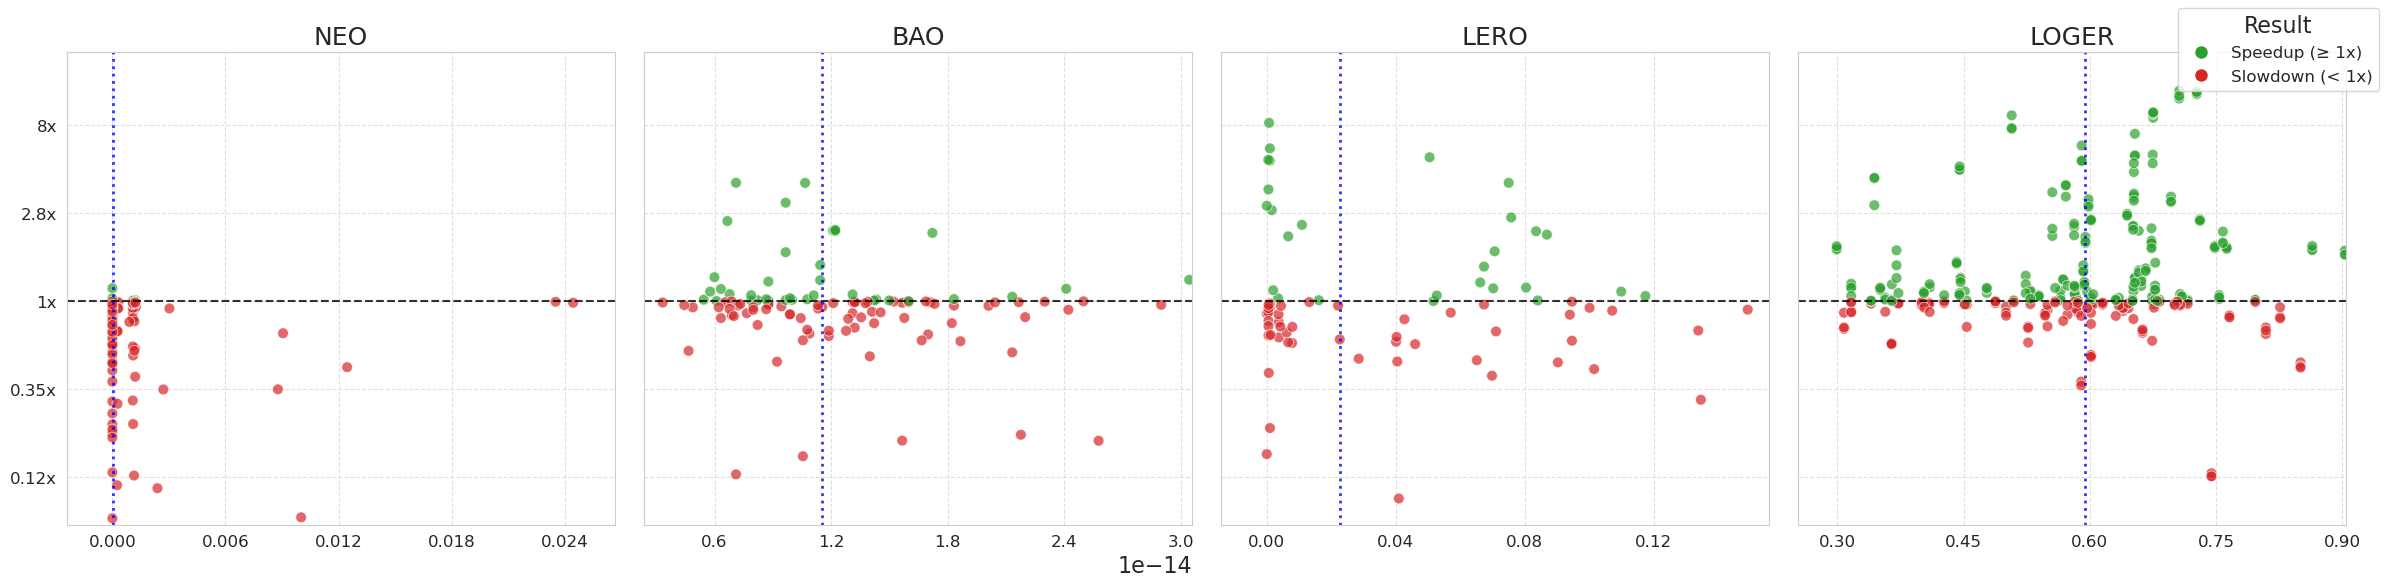

In [16]:
plots.plot_divergence_scatter_row_zoomed(df_all, PLOTS_DIR)

Loading BAO embeddings:   0%|          | 0/113 [00:00<?, ?it/s]

Loading LOGER embeddings: 100%|██████████| 339/339 [00:00<00:00, 2668.49it/s]
/data/hdd1/users/kmparmp/miniconda3/envs/jobgen/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Running t-SNE for BAO...

Running t-SNE for LERO...


/data/hdd1/users/kmparmp/miniconda3/envs/jobgen/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Running t-SNE for LOGER...


/data/hdd1/users/kmparmp/miniconda3/envs/jobgen/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Running t-SNE for NEO...


/data/hdd1/users/kmparmp/miniconda3/envs/jobgen/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Combined t-SNE plot saved to: /data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/experiments/experiment4/plots/4.4/all_optimizers_tsne_visualization.png


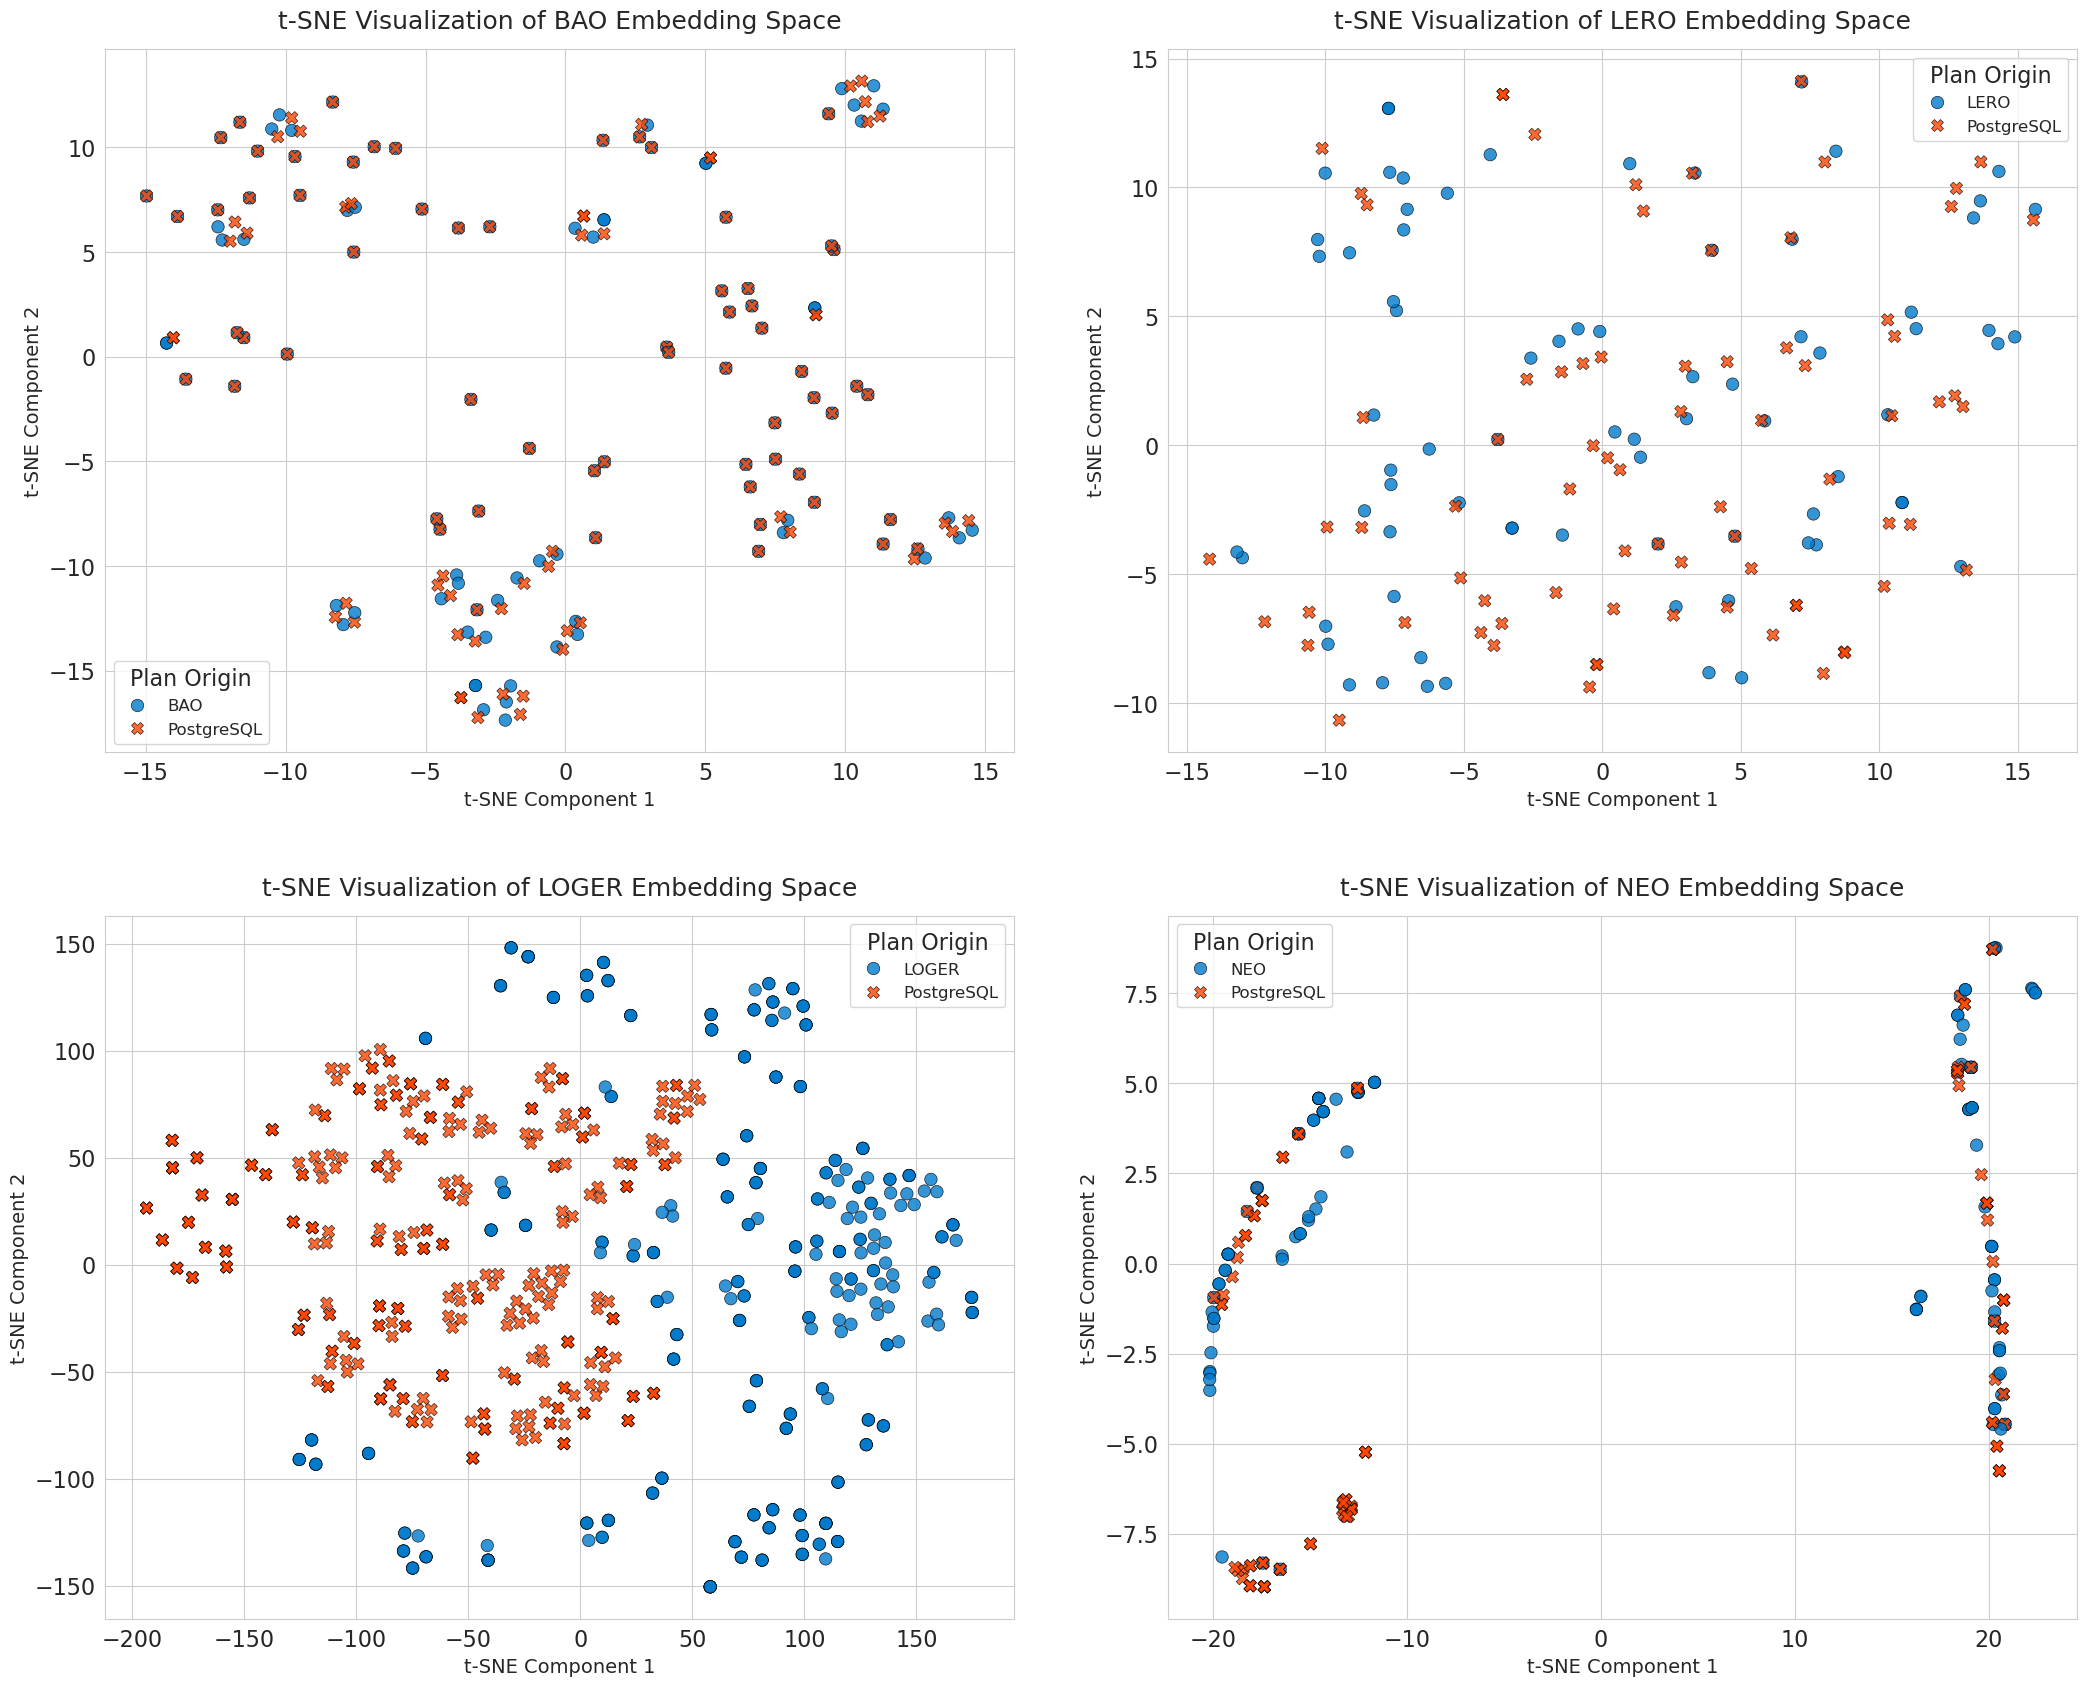

In [17]:
df_tsne = utils.load_and_transform_for_tsne(EXP_ROOT)

# --- Run the t-SNE Plotting ---
if 'df_tsne' in locals() and not df_tsne.empty:
    plots.plot_tsne_analysis(df_tsne, PLOTS_DIR)

In [18]:
df_tsne = utils.load_and_transform_for_tsne(EXP_ROOT)

# --- Run the t-SNE Plotting ---
if 'df_tsne' in locals() and not df_tsne.empty:
    plots.plot_tsne_analysis_per_optimizer(df_tsne, PLOTS_DIR)

Loading LERO embeddings:   0%|          | 0/113 [00:00<?, ?it/s]

Loading LOGER embeddings: 100%|██████████| 339/339 [00:00<00:00, 2669.52it/s]
/data/hdd1/users/kmparmp/miniconda3/envs/jobgen/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Running t-SNE for BAO...

Running t-SNE for LERO...


/data/hdd1/users/kmparmp/miniconda3/envs/jobgen/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Running t-SNE for LOGER...


/data/hdd1/users/kmparmp/miniconda3/envs/jobgen/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Running t-SNE for NEO...


/data/hdd1/users/kmparmp/miniconda3/envs/jobgen/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE plot for 'BAO' saved to: /data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/experiments/experiment4/plots/4.4/tsne_visualization_BAO.png
t-SNE plot for 'LERO' saved to: /data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/experiments/experiment4/plots/4.4/tsne_visualization_LERO.png
t-SNE plot for 'LOGER' saved to: /data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/experiments/experiment4/plots/4.4/tsne_visualization_LOGER.png
t-SNE plot for 'NEO' saved to: /data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/experiments/experiment4/plots/4.4/tsne_visualization_NEO.png


### Experiment 4.5

Evaluate the LQO’s ability to accurately estimate cardinalities and predict query latency:

1. **Cardinality Estimation Accuracy**: 
    - Q-Error Per Node: Compare estimated vs. actual cardinalities for each plan node.
    - Ablation Study: For workloads with poor cardinality estimation, test whether removing cardinality estimates from the encoding improves performance.

2. **Latency Prediction Accuracy**: 
    - Latency Q-Error: Measure the LQO’s ability to predict query execution latency for queries with varying join complexity.
    - Scalability Analysis: Assess whether latency prediction errors increase with higher join counts.

3. **Impact of Increasing Joins**: Track the Q-Error for cardinality estimates and latency predictions as the number of joins increases (e.g., 1 join vs. 5 joins vs. 10 joins).

**Goal**: Understand how well LQOs scale to complex queries and identify areas for improvement in cardinality estimation and latency prediction."			

In [19]:
# NOTE: The data source for this analysis is the 4.2 directory.
EXP_ROOT = os.path.join(BASE_DIR, "4.2")

print(f"Collecting Q-Error data for Experiment 4.4 from: {EXP_ROOT}")
q_errors = utils.collect_latency_q_errors(EXP_ROOT)

print(f"Data collection complete. Found data for join levels: {sorted(q_errors.keys())}")

Data collection complete. Found data for join levels: ['10', '11', '12', '13', '14', '16', '4', '5', '6', '7', '8', '9']



Generating Q-Error plots...
Saving line plot: plots/4.4/q_errors_avg_line_graph.png


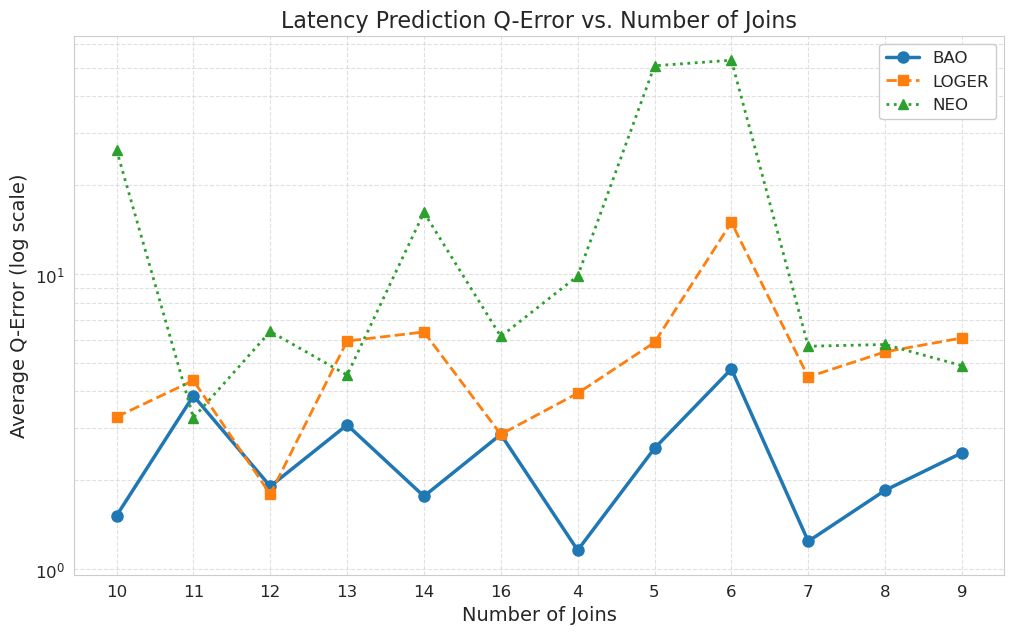

Saving bar plot: plots/4.4/q_errors_bar_graph.png


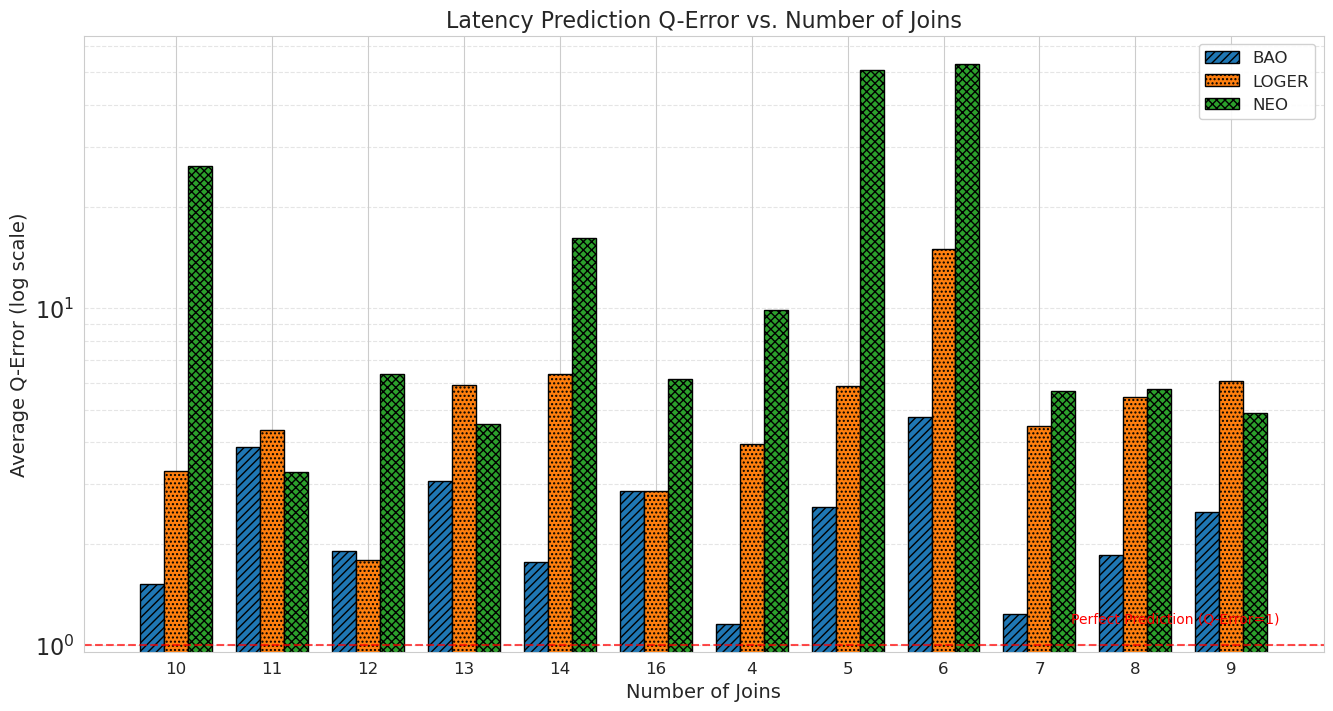


All plots for Experiment 4.4 generated.


In [20]:
print("\nGenerating Q-Error plots...")
plots.plot_q_errors_line(q_errors)
plots.plot_q_errors_bar(q_errors)
print("\nAll plots for Experiment 4.4 generated.")